Imports

In [1]:
#############
###paths#####
#############
import sys
import os

from importlib_metadata import distribution
pwd = os.getcwd()
modellingpath = pwd.rpartition("modelling")[0] + pwd.rpartition("modelling")[1] 
modellingephemeral = '/rds/general/ephemeral/user/mo2016/ephemeral/Documents/modelling'

sys.path.append(modellingpath + '/lib')
#############

from numerical.cn_plot import plot1D, surfpattern
from numerical.countPeaksAnalysisFunctions import countPeaks, varPeakDistFunction
from numerical.generalFunctions import round_it
from numerical.fourierAnalysisFunctions import psEntropyFunction, plotFourier


from analytical.linear_stability_analysis import detailed_turing_analysis_dict
from randomfunctions import plot_all_dispersion, plot_highest_dispersion

from scipy.signal import find_peaks
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm



System definitions

In [2]:
circuit_n='turinghill'
variant= 0
n_species=2
mechanism='nogrowth'
L=50; dx =1; J = int(L/dx)
T =500; dt = 0.005; N = int(T/dt)
boundaryCoeff=2;rate=0.1

L=100; dx =1; J = int(L/dx)
T =3000; dt = 0.005; N = int(T/dt)
boundaryCoeff=2;rate=0.1

filename= lambda mechanism, parID: 'circuit%s_variant%s_bc%s_%s_rate%s_ID%s_L%r_J%r_T%r_N%r'%(circuit_n,variant,boundaryCoeff, mechanism,rate,parID,L,J,T,N)
# filename= lambda mechanism, parID: '%s_variant%s_%s_ID%s_L%r_J%r_T%r_N%r'%(circuit_n,variant, mechanism,parID,L,J,T,N)
n_param_sets=2000000
lsa_df= pickle.load( open(modellingpath + '/growth/out/analytical/lsa_dataframes/lsa_df_%s_variant%r_%rparametersets.pkl'%(circuit_n,variant,n_param_sets), "rb"))
# single_lsa_df =  lsa_df.xs(0, level=1)
parID_list = pickle.load(open( modellingephemeral + '/growth/out/numerical/%s/%s/simulation/parID_list_%s.pkl'%(circuit_n,mechanism,filename(mechanism,'x')), "rb" ) )
# parID_list = [int(parID) for parID in parID_list]
instability_df= pickle.load( open(modellingpath + '/growth/out/analytical/instability/instability_df_%s_variant%r_%rparametersets.pkl'%(circuit_n,variant,n_param_sets), "rb"))
# singleSsInstability_df = instability_df.loc[instability_df['ss_n']==1]
# singleSsInstability_df
# pattern_df = pickle.load(open( modellingpath + '/growth/out/patternAnalysis/%s/%s/pattern/pattern_df_%s.pkl'%(circuit_n,mechanism,filename(mechanism,'x')), 'rb'))



In [3]:
# df1 = pattern_df.loc[(pattern_df['system_class']=='hopf') ]
# print(df1['pattern'].value_counts())

# df1 = instability_df.loc[(instability_df['system_class']=='turing I hopf') ]
df1=instability_df
print(instability_df['system_class'].value_counts())

hopf                    61890
turing I hopf            1047
turing I oscillatory       29
turing I                    2
Name: system_class, dtype: int64


Functions

In [11]:
def parID_display(parIDss, L,J,T,round=False,crop=100,ss_n=0,df = df1):
    #data
    U_final = pickle.load( open(modellingephemeral + '/growth/out/numerical/%s/%s/simulation/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))
    plot1D(U_final,round=round)

    plt.subplots(figsize=(10,4))

    #dispersion
    plt.subplot(131)
    parID_dispersion(parIDss,crop)

    #convergence
    plt.subplot(132)
    parID_surfpattern(parIDss,L,J,T,morphogen=1)
    plt.tight_layout()
    plt.subplot(133)
    parID_surfpattern(parIDss,L,J,T,morphogen=1)
    plt.tight_layout()

    plt.show()
def parID_surfpattern(parIDss,L,J,T,record_every_x_hours = 10):
    #data 
    U_record = pickle.load( open(modellingephemeral + '/growth/out/numerical/%s/%s/simulation/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))    
    #grids
    dx = float(L)/float(J-1)
    x_grid = np.array([j*dx for j in range(J)])
    reduced_t_grid = np.arange(0,T,record_every_x_hours) 

    #plot
    surfpattern(U_record, [x_grid, reduced_t_grid], 'linear',  morphogen=1, rate=0, savefig=False,filename='',logResults=False,normalize=False)


def parID_dispersion(parIDss,crop, df = df1):
    #dispersion
    parID,ss = [int(x) for x in parIDss.split('.')]
    par_dict = df.loc[(parID,ss)].to_dict() #converts a dataframe row into a dictionary outputing a dictionary for a specific parameter set
    
    # par_dict = df.loc[parIDss].to_dict() #converts a dataframe row into a dictionary outputing a dictionary for a specific parameter set
    out = detailed_turing_analysis_dict(par_dict, circuit_n, n_species)
    plot_highest_dispersion(out[-3][1-1],crop=crop)


In [15]:
def countPeaks(U, showPlot1D=True):
    peaks = [0,0]
    peaks[0], _ = find_peaks(U[0], prominence=0.1)
    peaks[1], _ = find_peaks(U[1], prominence=0.1)
    if showPlot1D == True:
        plot1D(U,plotPeaks=True, peaks=peaks)

    return peaks

In [14]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data)+1e-8)

In [16]:
def patternClassification(U_final, U_record, normalize=True):
    #check if flat
    relRange = [(np.amax(U) - np.amin(U))/(np.amax(U)+1e-8) for U in U_final]
    if any(i<0.001 for i in relRange):
        flat=True
    else:
        flat=False
    # diffUfinal = np.round(np.diff(U_final),decimals=3)
    # #Check if flat0
    # if np.all(diffUfinal==0)==True:
    #     flat=True
    # else:
    #     flat=False

    #check if convergence with diff function
    diffUrecord = np.round(np.diff(U_record[1][-10:], axis=0),decimals=3)
    
    if np.all(diffUrecord==0) ==True:
        converged=True
    else:
        converged=False

    #check if regular
    if flat==True:
        plot=False
    else:
        plot=True
    U_final_norm = [NormalizeData(U) for U in U_final]
    peaks = countPeaks(U_final_norm, showPlot1D=True)

    #calculate distance between peaks in peak0
    var=[0,0]
    for count,singleUpeak in enumerate(peaks):
        print(singleUpeak)
        if len(singleUpeak)>2:
            peak_dist = [np.linalg.norm(singleUpeak[i]-singleUpeak[i+1]) for i in range(len(singleUpeak)-1)]
            peak_dist = peak_dist/np.sum(peak_dist)
            var[count] = np.std(peak_dist)
        else:
            var[count] = 1
    print(f'var = {var}')
    if var[0]<0.001 and var[1]<0.001:
        regular=True
    else:
        regular=False
        


    if flat==True and converged==True:
        pattern='Homogeneous'
    if flat==True and converged==False:
        pattern='Temporal Oscillator'
    if flat==False and converged==True and regular==True:
        pattern = 'Stationary regular pattern'
    if flat==False and converged==True and regular==False:
        pattern = 'Stationary irregular pattern'

    if flat==False and converged==False and regular==True:
        pattern = 'Non-Stationary regular pattern'
    if flat==False and converged==False and regular==False:
        pattern = 'Non-Stationary irregular pattern'
    # if var[0]>0.1 and var[1]>0.1:





    return converged, flat, regular



1593460.0


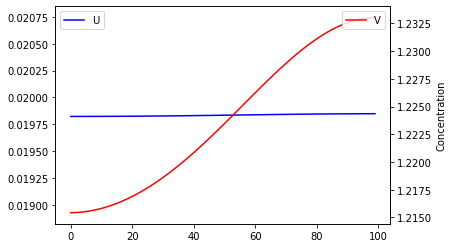

<ipython-input-11-01a31d747de6>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


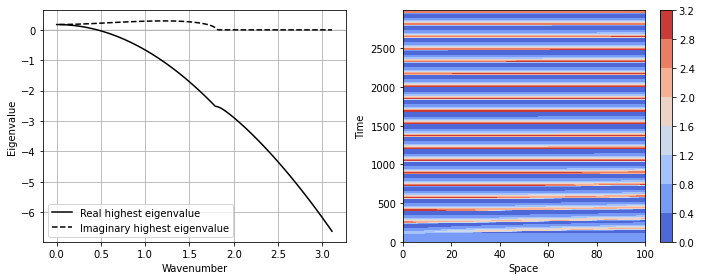

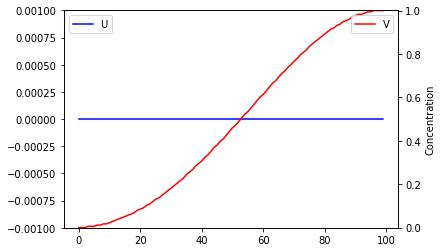

[]
[]
var = [1, 1]


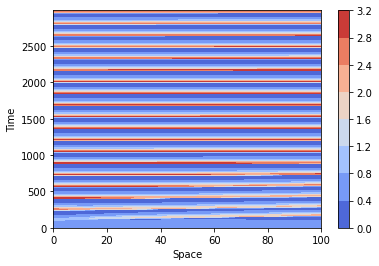

Converged = False, Flat = True, Regular = False
-----------------------------------
1972524.0


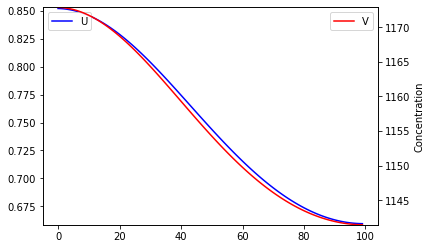

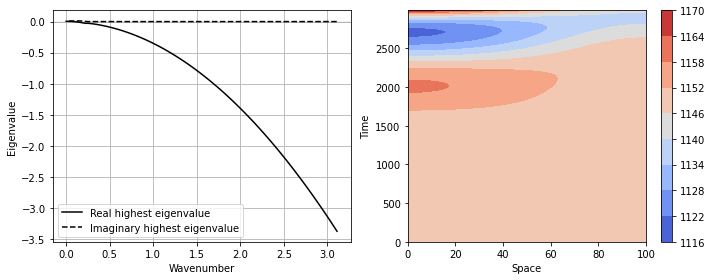

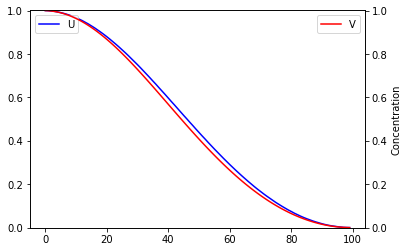

[]
[]
var = [1, 1]


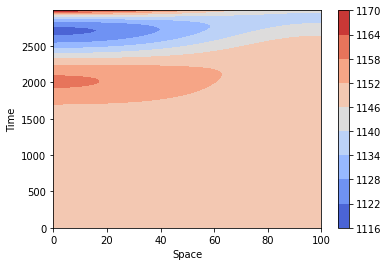

Converged = False, Flat = False, Regular = False
-----------------------------------
593054.2


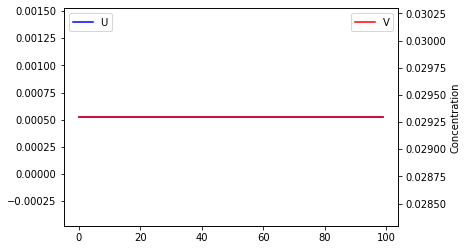

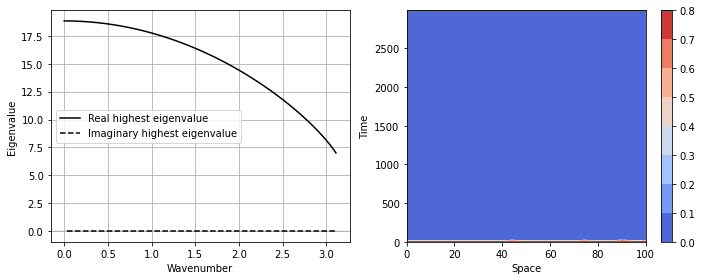

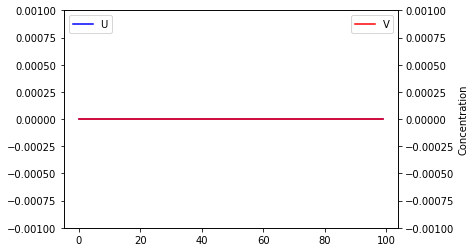

[]
[]
var = [1, 1]


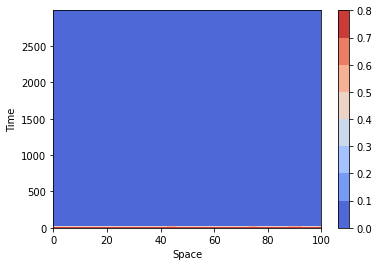

Converged = True, Flat = True, Regular = False
-----------------------------------
1932431.0


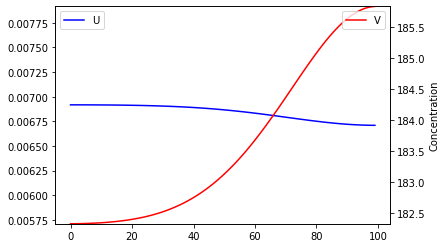

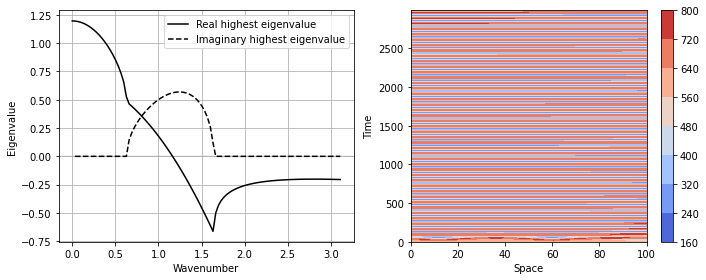

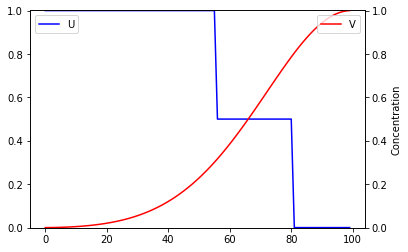

[]
[]
var = [1, 1]


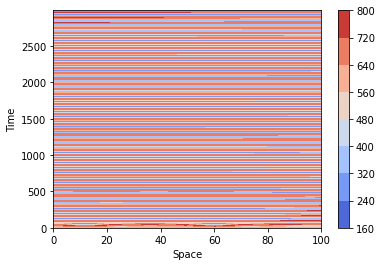

Converged = False, Flat = False, Regular = False
-----------------------------------
1837551.2


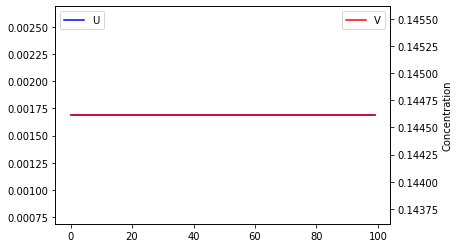

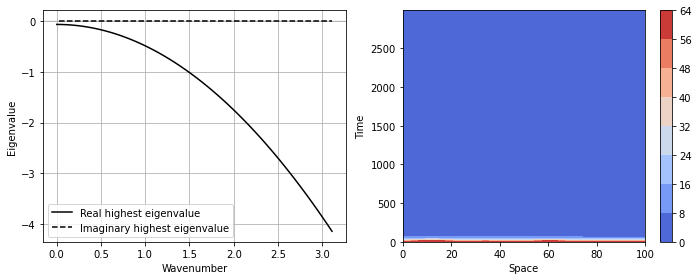

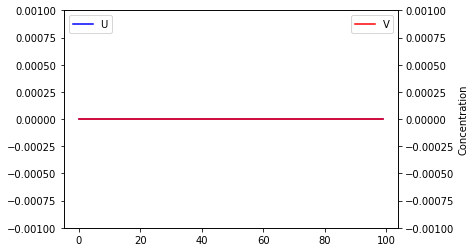

[]
[]
var = [1, 1]


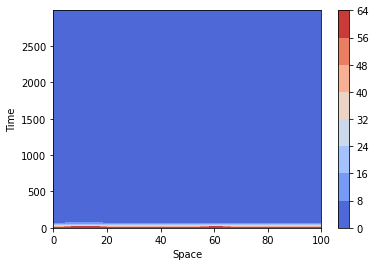

Converged = True, Flat = True, Regular = False
-----------------------------------
461625.0


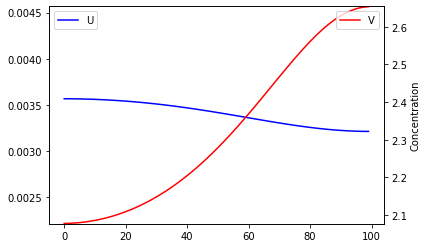

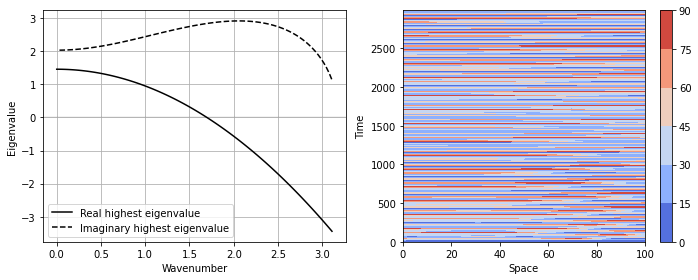

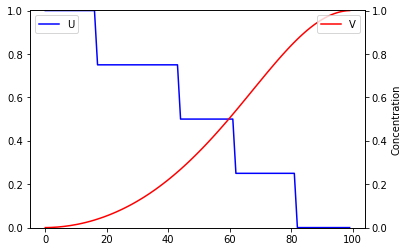

[]
[]
var = [1, 1]


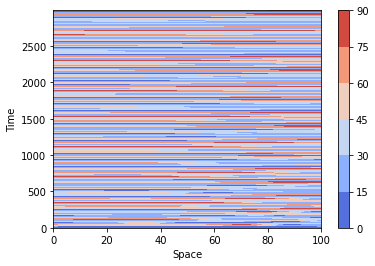

Converged = False, Flat = False, Regular = False
-----------------------------------
212436.2


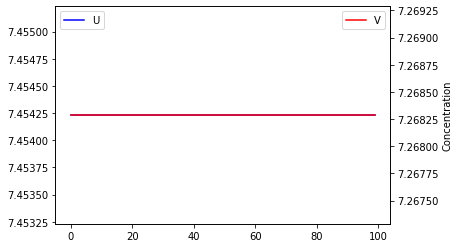

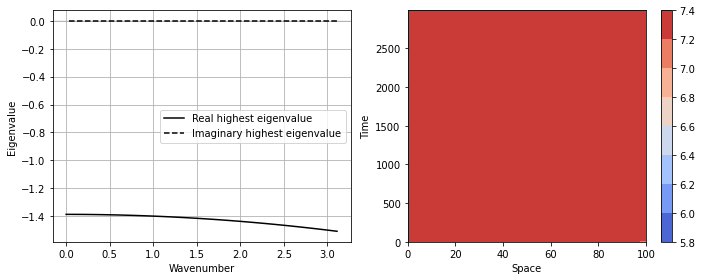

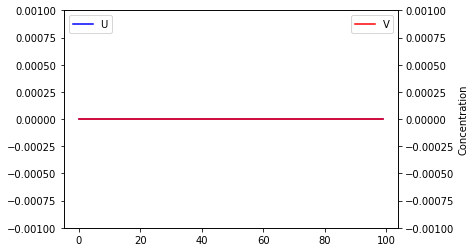

[]
[]
var = [1, 1]


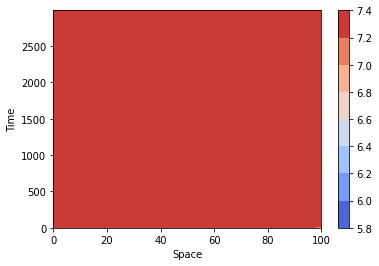

Converged = True, Flat = True, Regular = False
-----------------------------------
1928703.0


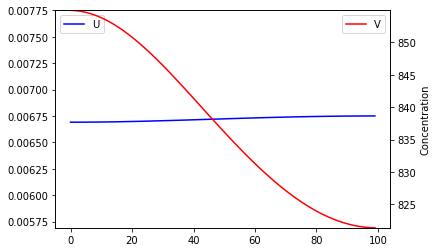

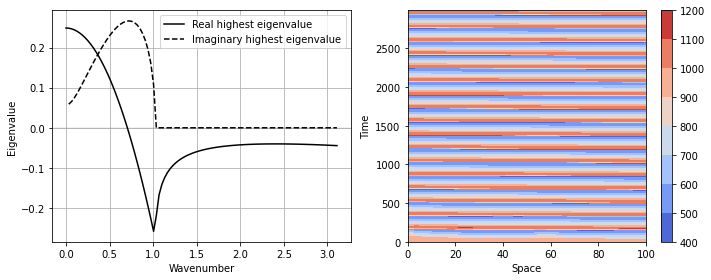

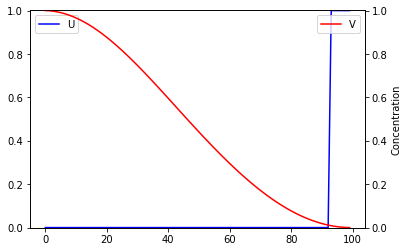

[]
[]
var = [1, 1]


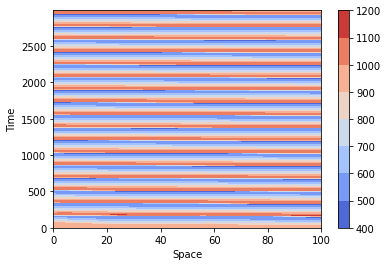

Converged = False, Flat = False, Regular = False
-----------------------------------
214700.1


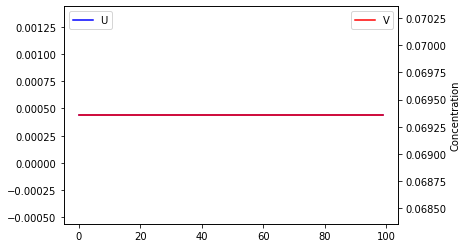

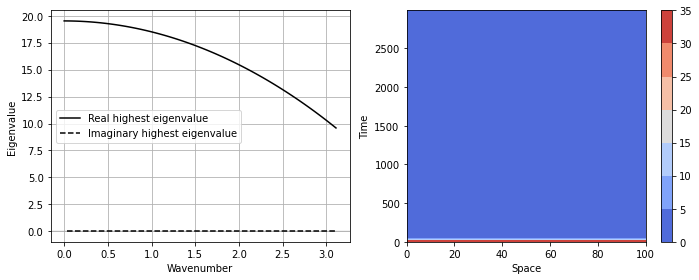

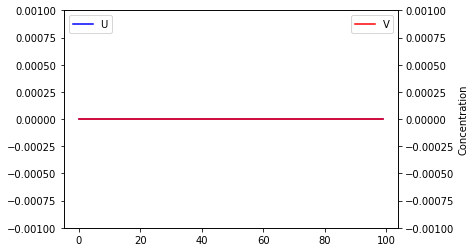

[]
[]
var = [1, 1]


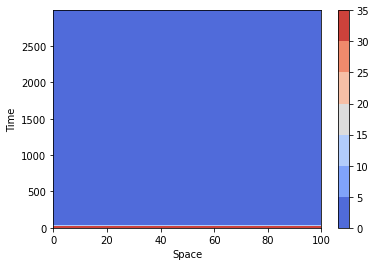

Converged = True, Flat = True, Regular = False
-----------------------------------
1219071.0


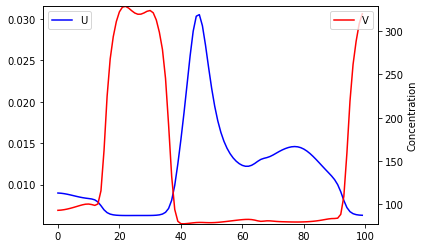

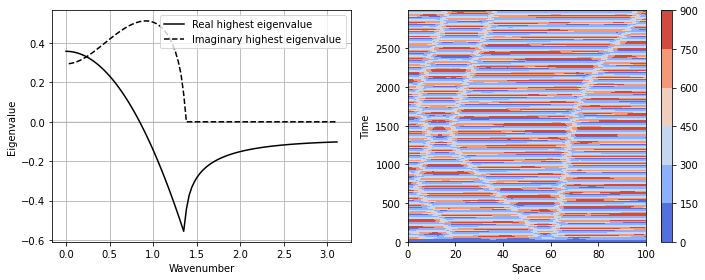

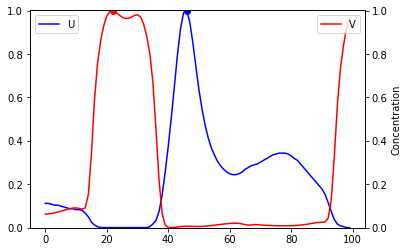

[46]
[22]
var = [1, 1]


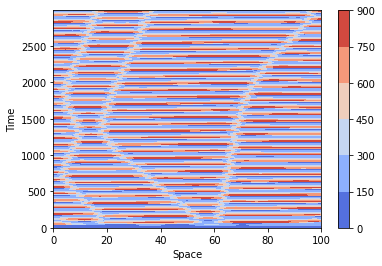

Converged = False, Flat = False, Regular = False
-----------------------------------
1013002.0


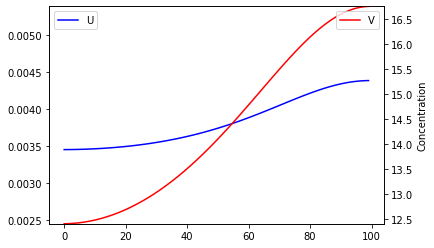

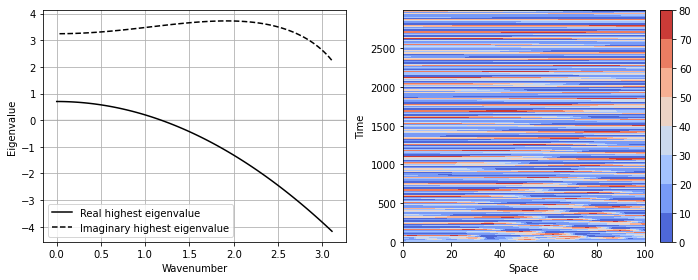

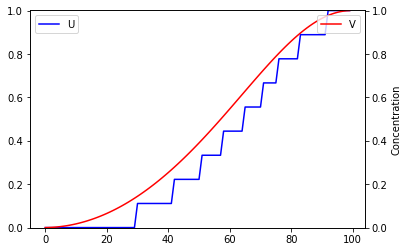

[]
[]
var = [1, 1]


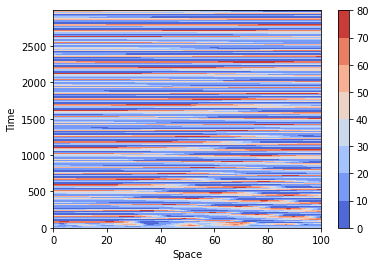

Converged = False, Flat = False, Regular = False
-----------------------------------
1042587.2


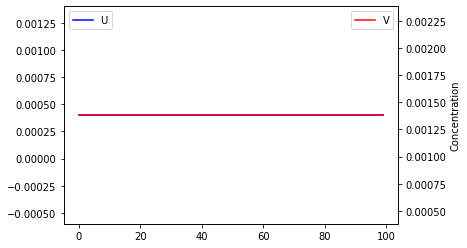

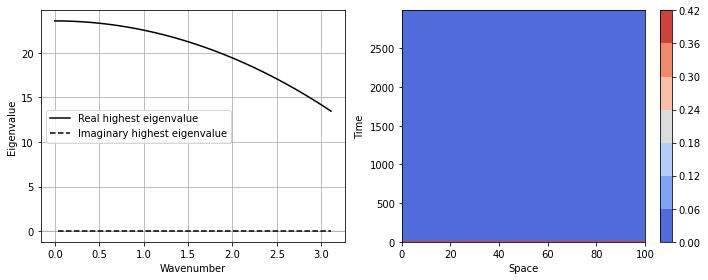

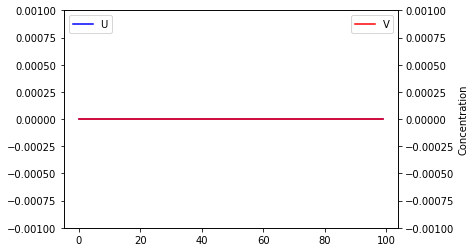

[]
[]
var = [1, 1]


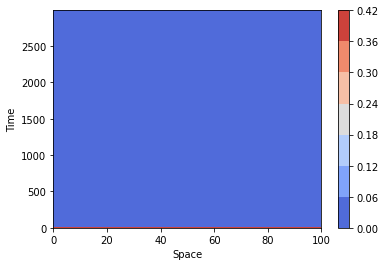

Converged = True, Flat = True, Regular = False
-----------------------------------
1842911.2


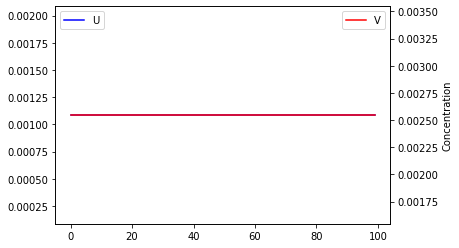

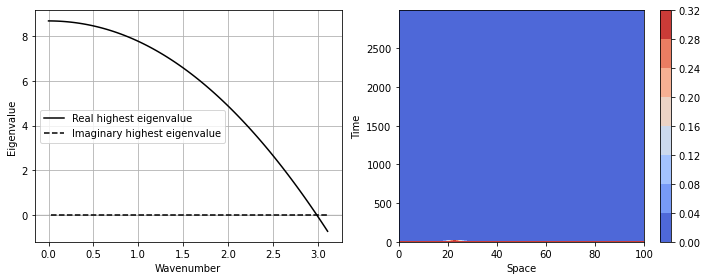

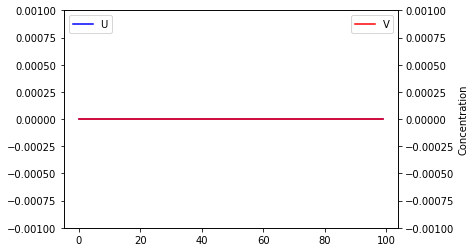

[]
[]
var = [1, 1]


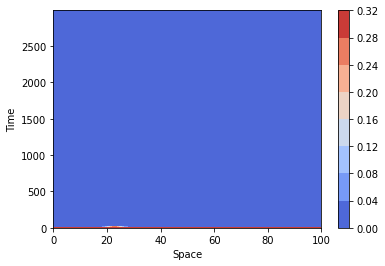

Converged = True, Flat = True, Regular = False
-----------------------------------
1834682.0


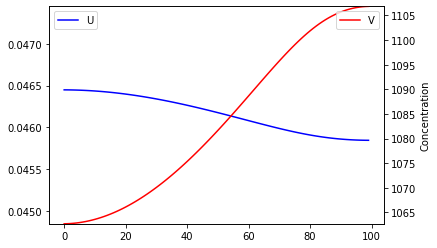

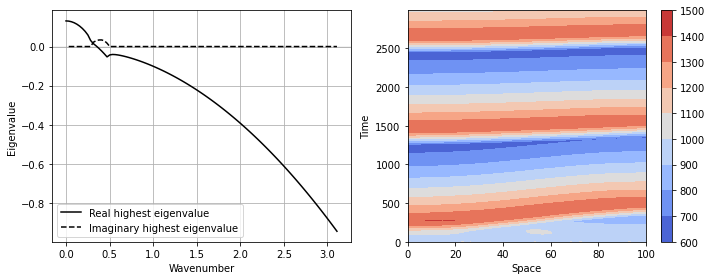

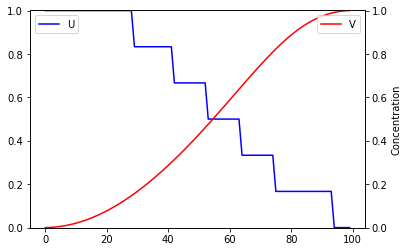

[]
[]
var = [1, 1]


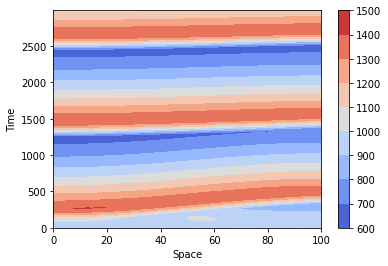

Converged = False, Flat = False, Regular = False
-----------------------------------
1456961.0


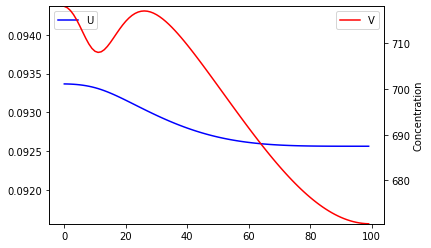

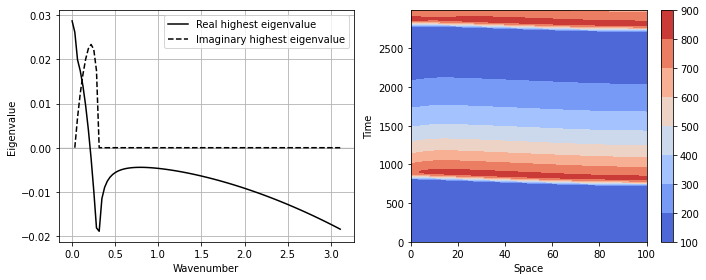

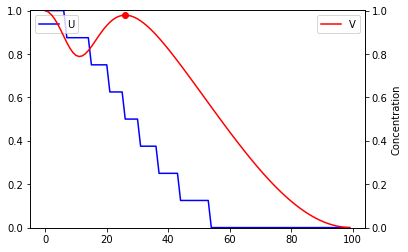

[]
[26]
var = [1, 1]


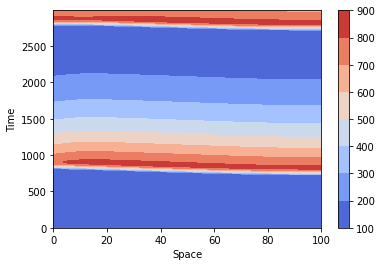

Converged = False, Flat = False, Regular = False
-----------------------------------
807620.0


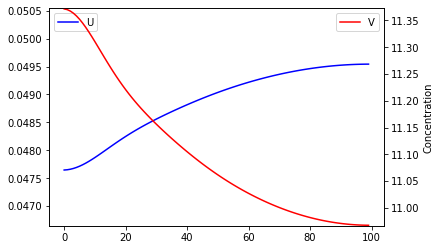

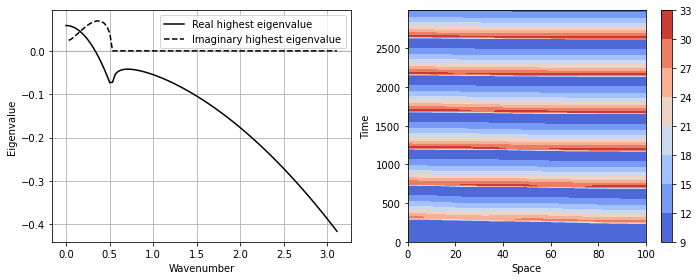

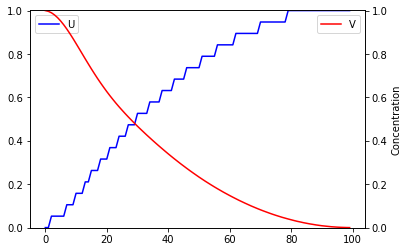

[]
[]
var = [1, 1]


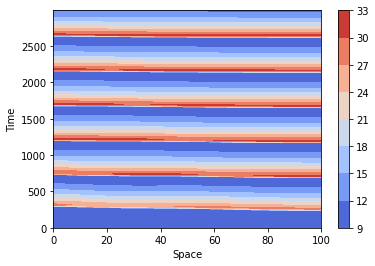

Converged = False, Flat = False, Regular = False
-----------------------------------
842371.0


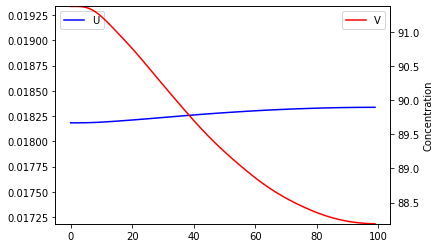

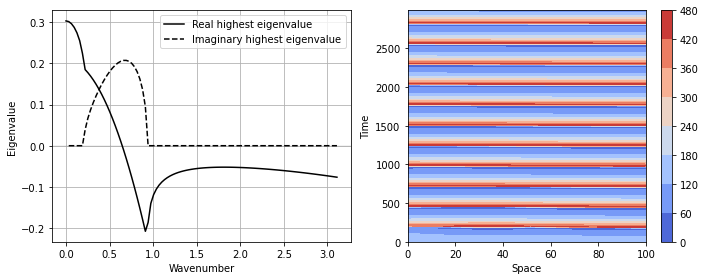

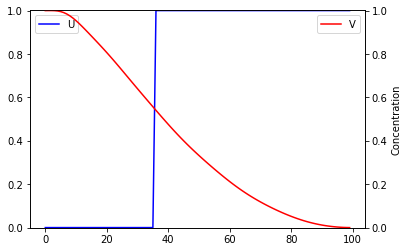

[]
[]
var = [1, 1]


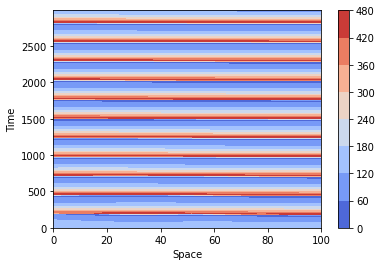

Converged = False, Flat = False, Regular = False
-----------------------------------
1298924.0


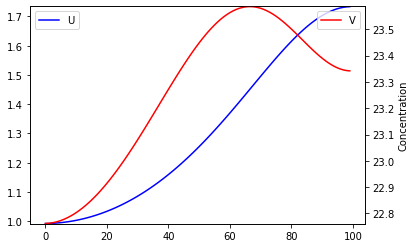

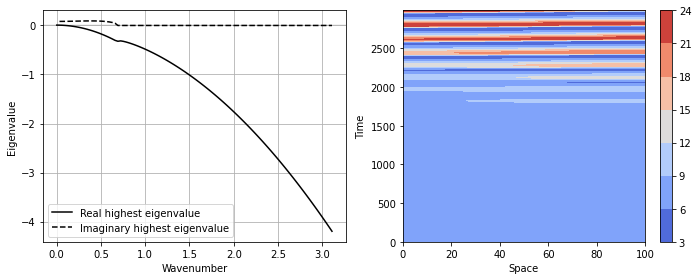

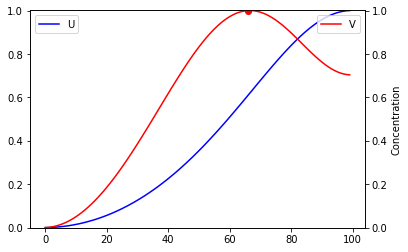

[]
[66]
var = [1, 1]


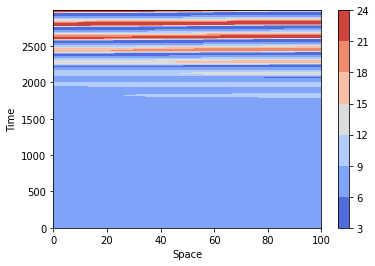

Converged = False, Flat = False, Regular = False
-----------------------------------
342122.0


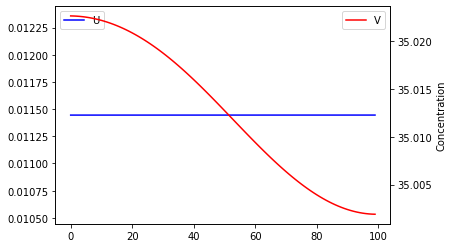

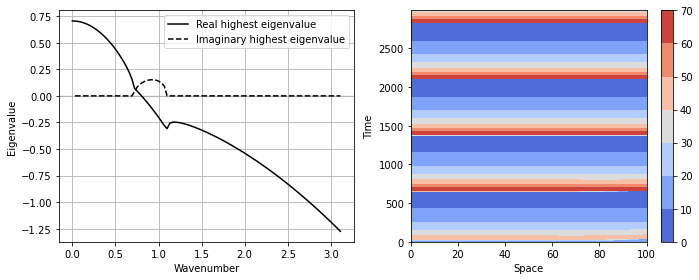

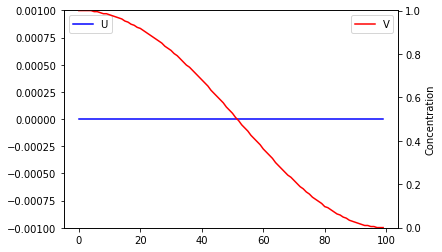

[]
[]
var = [1, 1]


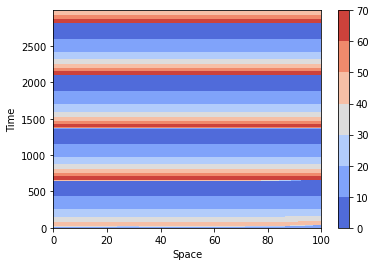

Converged = False, Flat = True, Regular = False
-----------------------------------
1419278.0


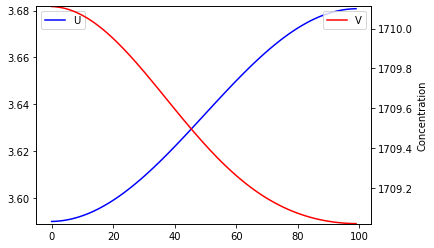

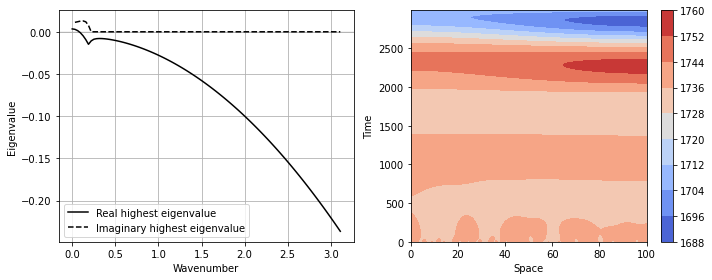

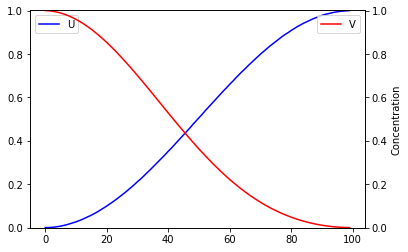

[]
[]
var = [1, 1]


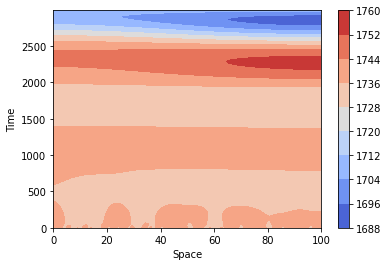

Converged = False, Flat = True, Regular = False
-----------------------------------
1551084.0


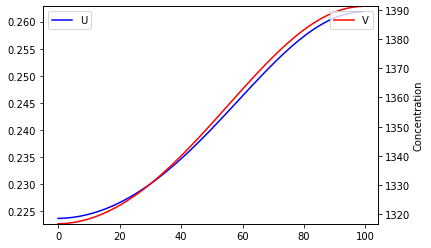

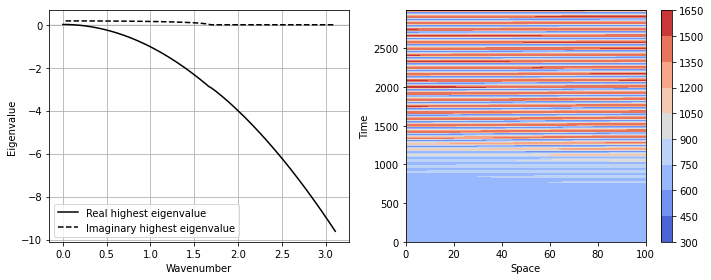

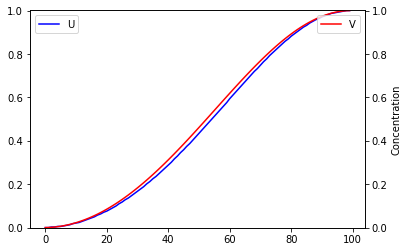

[]
[]
var = [1, 1]


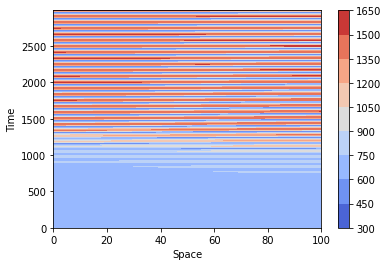

Converged = False, Flat = False, Regular = False
-----------------------------------
460445.0


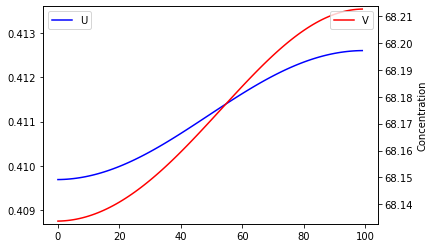

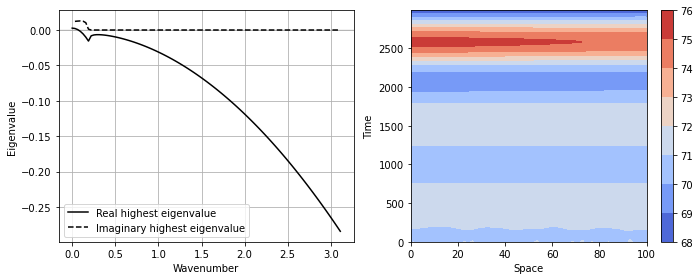

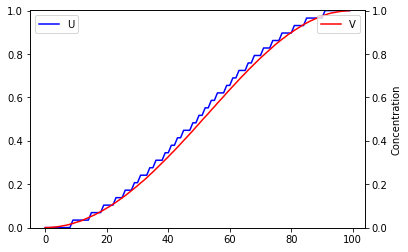

[]
[]
var = [1, 1]


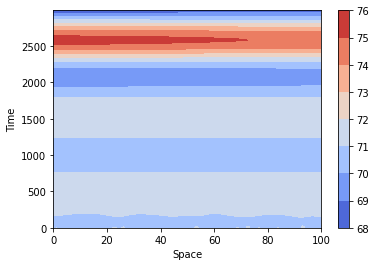

Converged = False, Flat = False, Regular = False
-----------------------------------
794644.2


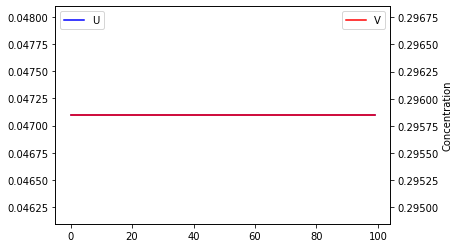

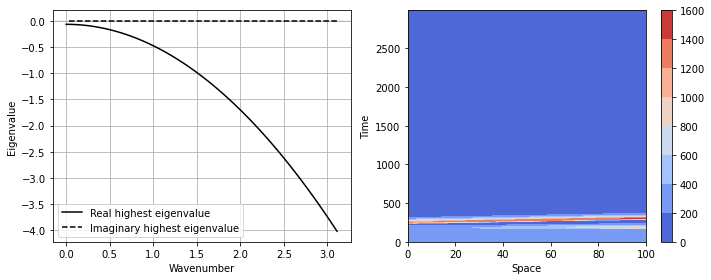

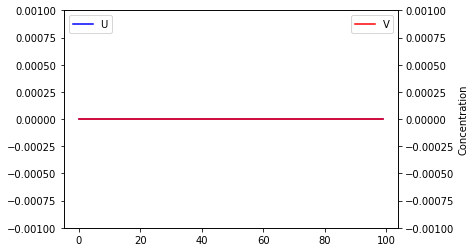

[]
[]
var = [1, 1]


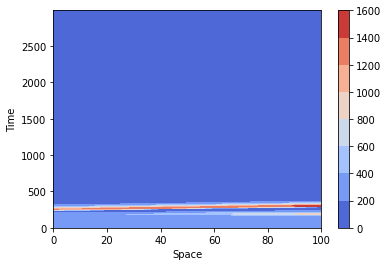

Converged = True, Flat = True, Regular = False
-----------------------------------
52385.0


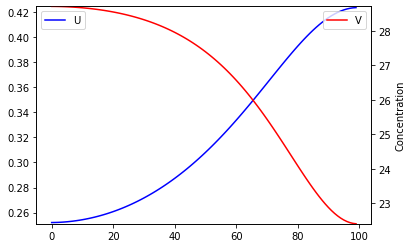

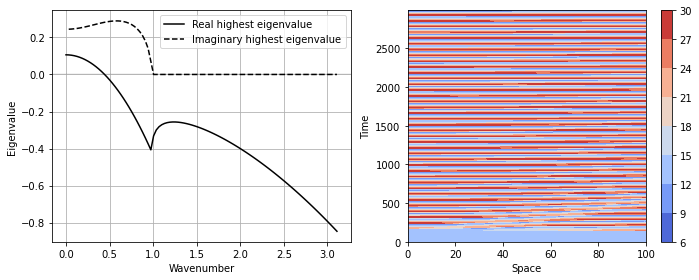

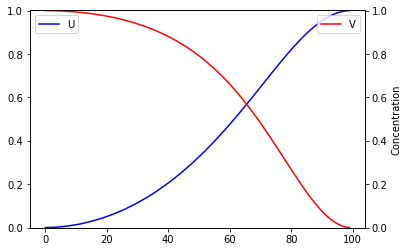

[]
[]
var = [1, 1]


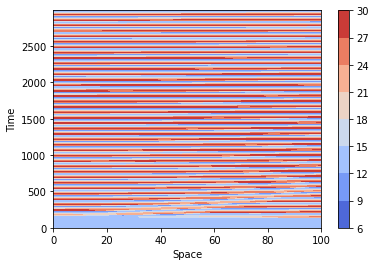

Converged = False, Flat = False, Regular = False
-----------------------------------
1801294.2


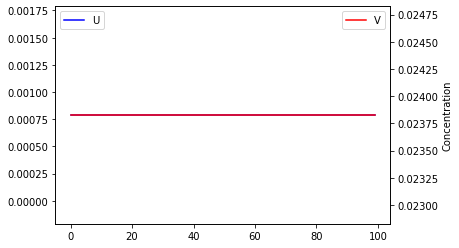

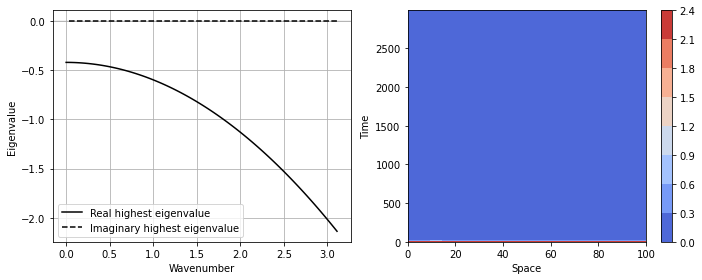

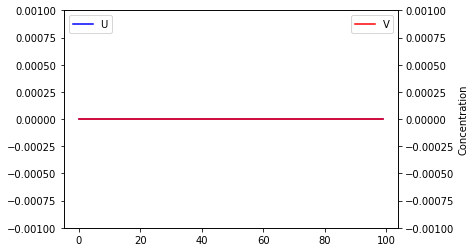

[]
[]
var = [1, 1]


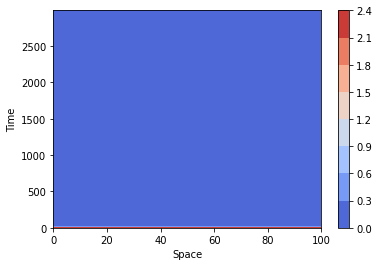

Converged = True, Flat = True, Regular = False
-----------------------------------
1469385.0


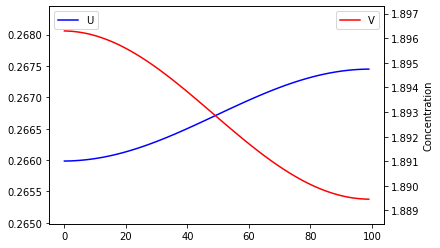

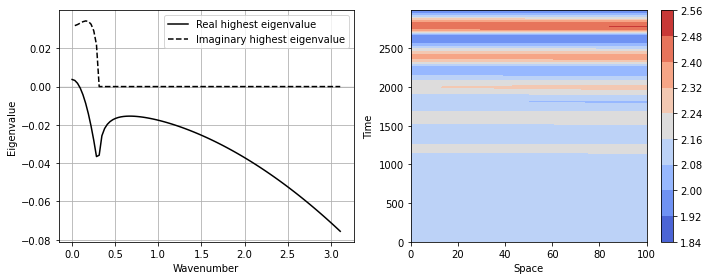

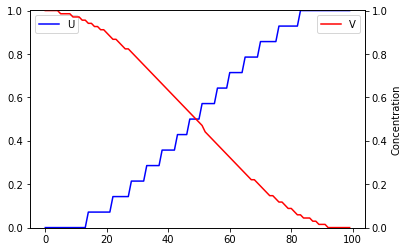

[]
[]
var = [1, 1]


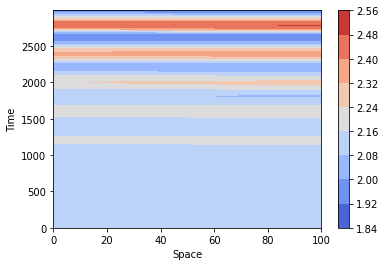

Converged = False, Flat = False, Regular = False
-----------------------------------
1175411.0


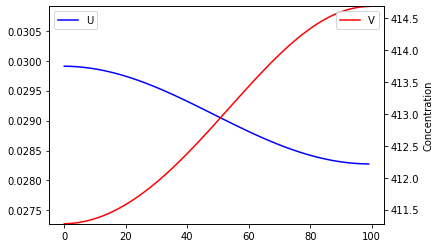

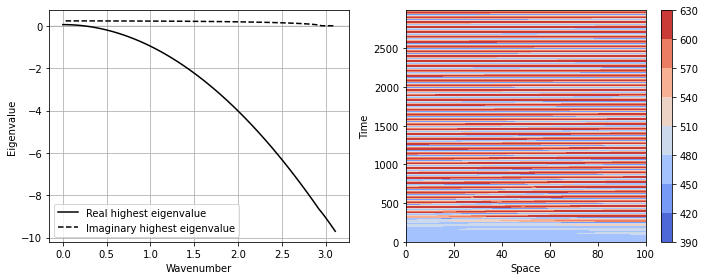

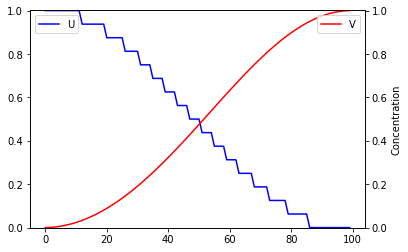

[]
[]
var = [1, 1]


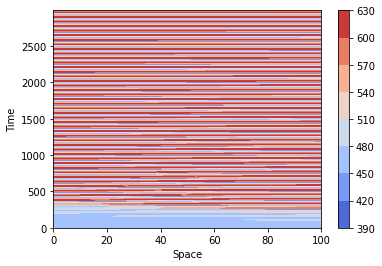

Converged = False, Flat = False, Regular = False
-----------------------------------
673108.0


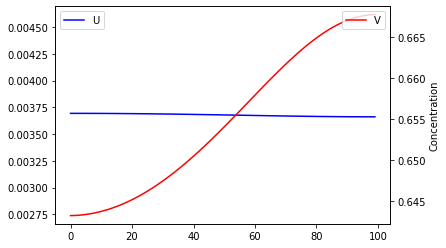

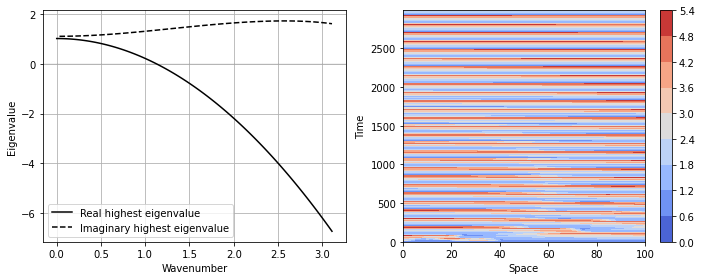

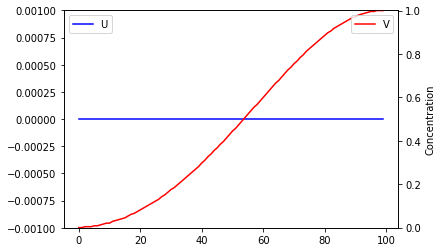

[]
[]
var = [1, 1]


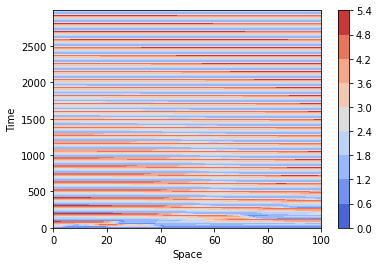

Converged = False, Flat = True, Regular = False
-----------------------------------
878859.2


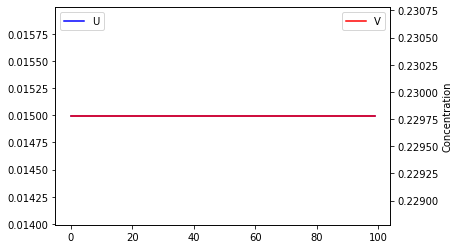

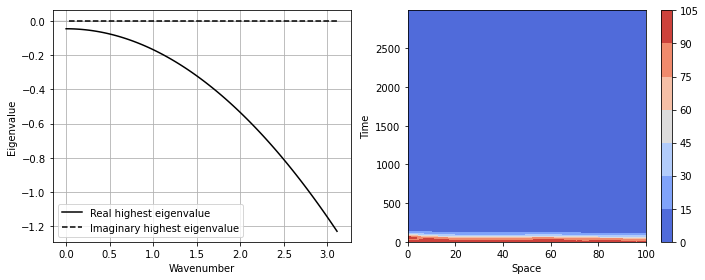

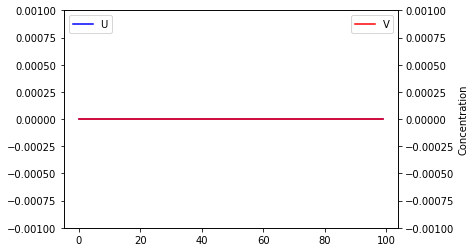

[]
[]
var = [1, 1]


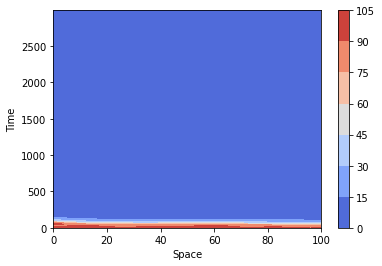

Converged = True, Flat = True, Regular = False
-----------------------------------
547196.0


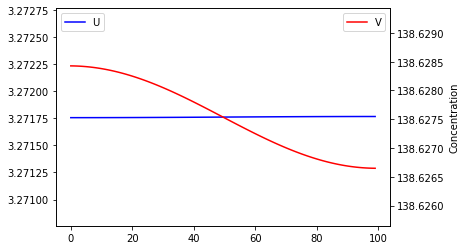

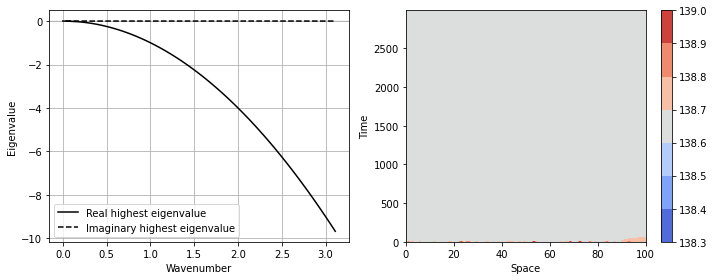

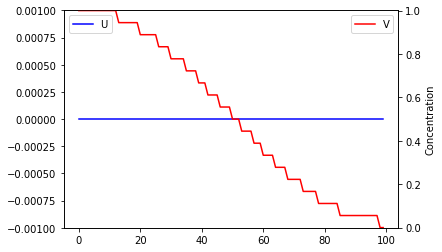

[]
[]
var = [1, 1]


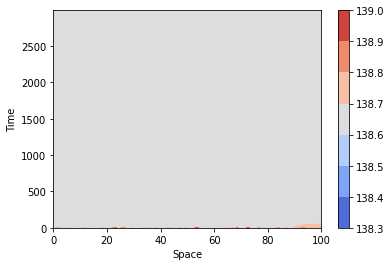

Converged = False, Flat = True, Regular = False
-----------------------------------
174454.1


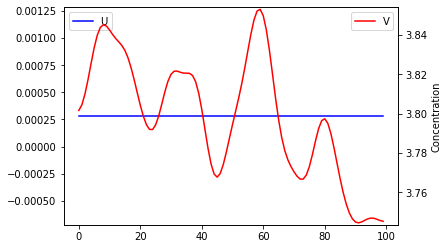

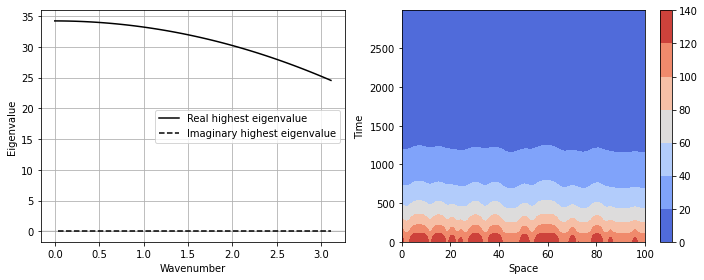

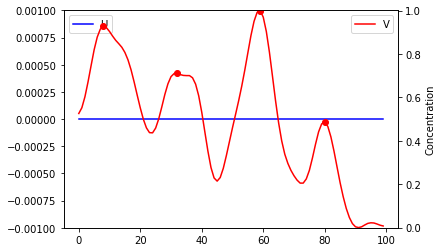

[]
[ 8 32 59 80]
var = [1, 0.03402069087198858]


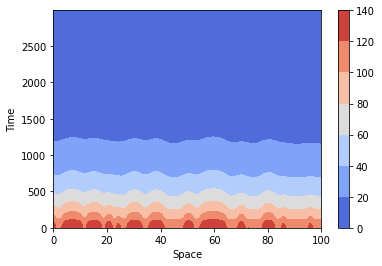

Converged = False, Flat = True, Regular = False
-----------------------------------
1252046.2


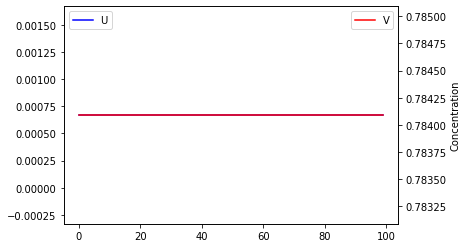

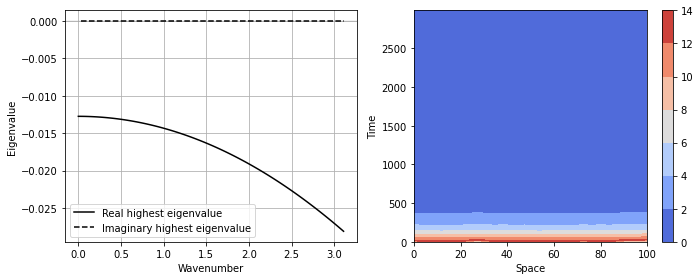

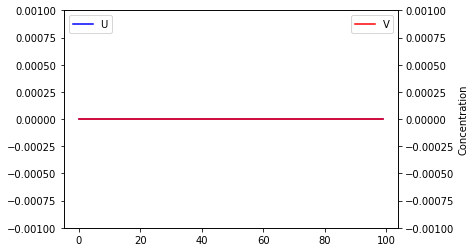

[]
[]
var = [1, 1]


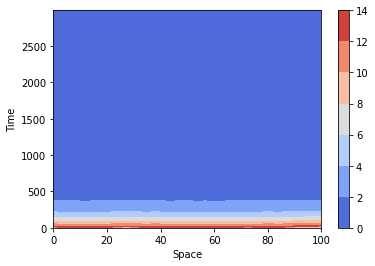

Converged = True, Flat = True, Regular = False
-----------------------------------
1839418.0


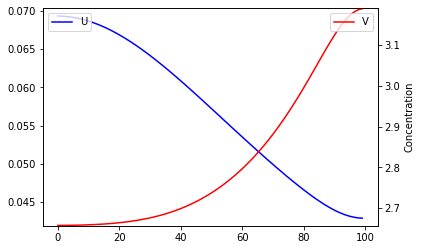

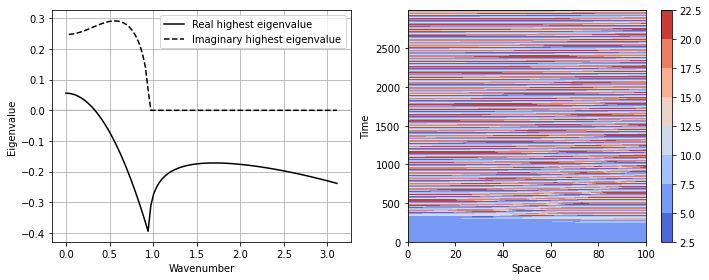

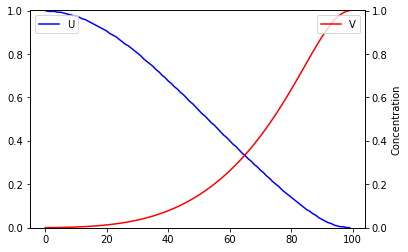

[]
[]
var = [1, 1]


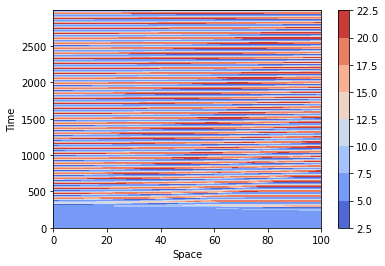

Converged = False, Flat = False, Regular = False
-----------------------------------
1250527.0


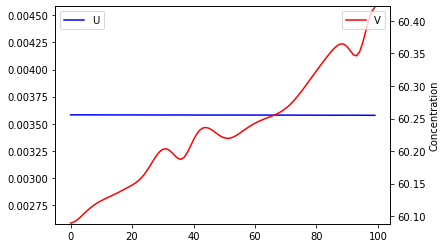

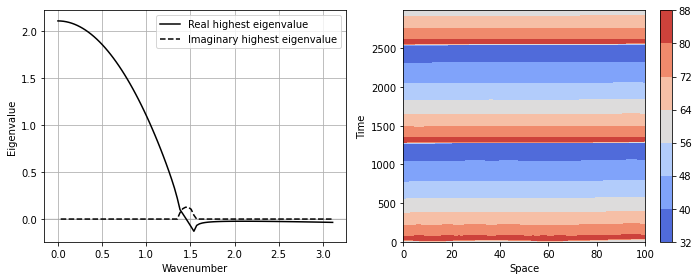

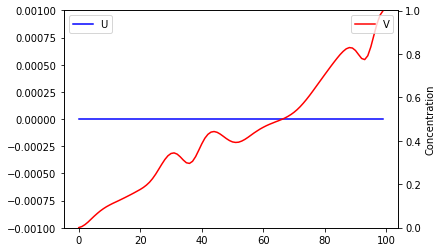

[]
[]
var = [1, 1]


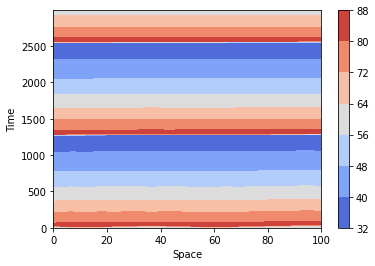

Converged = False, Flat = True, Regular = False
-----------------------------------
1215003.0


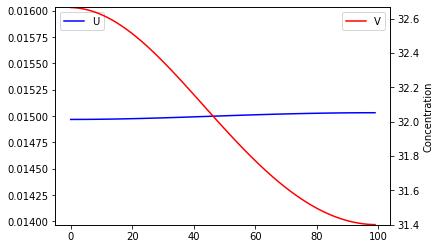

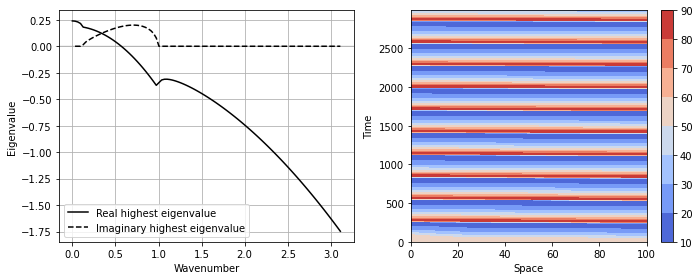

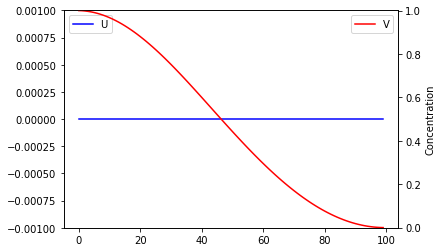

[]
[]
var = [1, 1]


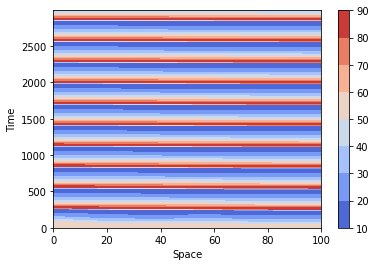

Converged = False, Flat = True, Regular = False
-----------------------------------
1970211.0


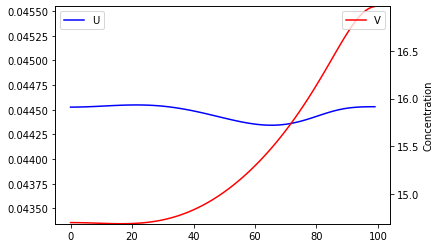

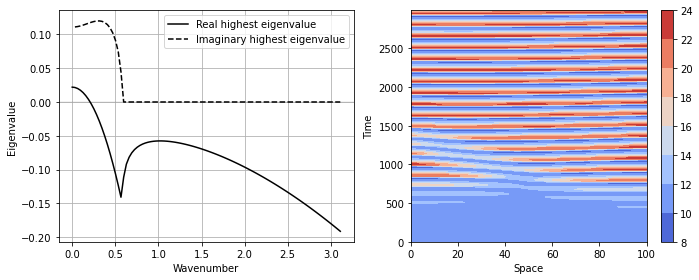

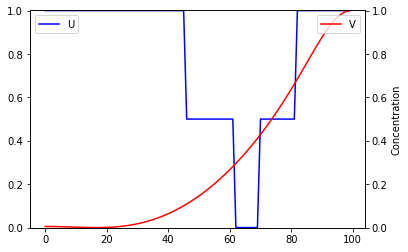

[]
[]
var = [1, 1]


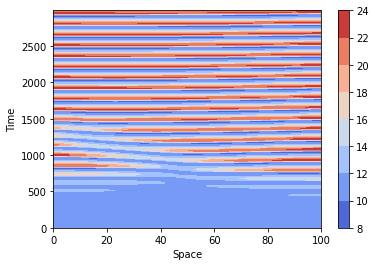

Converged = False, Flat = False, Regular = False
-----------------------------------
633469.0


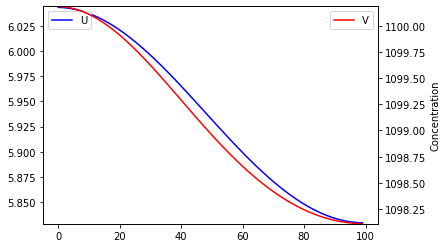

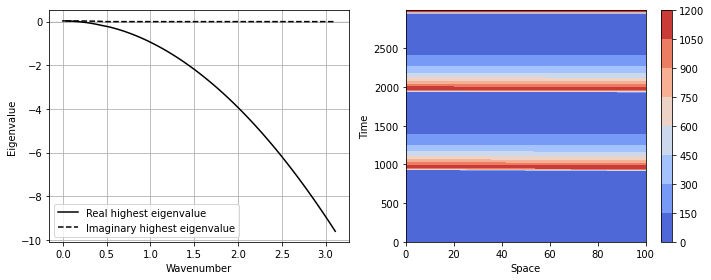

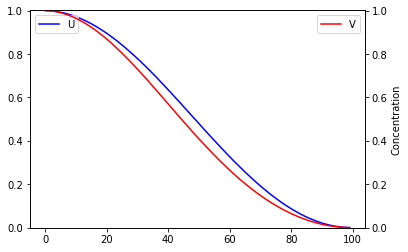

[]
[]
var = [1, 1]


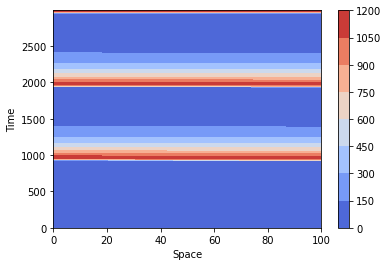

Converged = False, Flat = False, Regular = False
-----------------------------------
791623.0


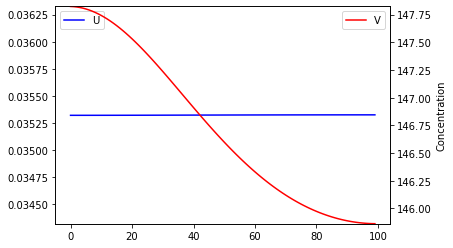

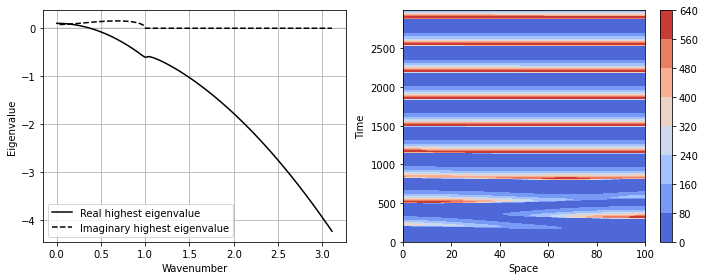

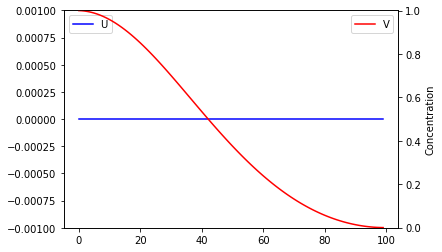

[]
[]
var = [1, 1]


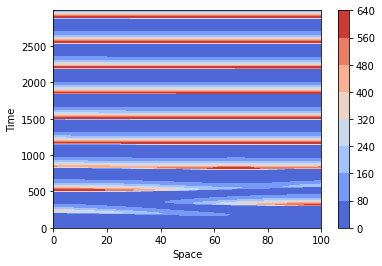

Converged = False, Flat = True, Regular = False
-----------------------------------
262594.2


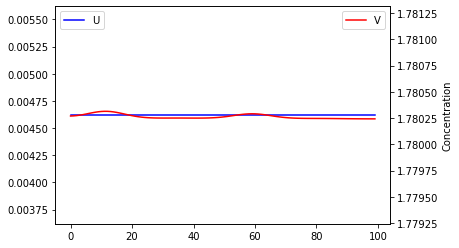

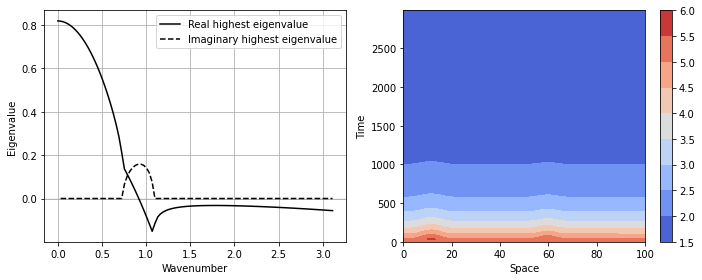

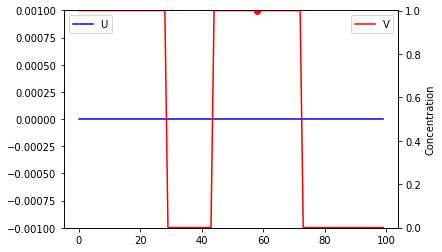

[]
[58]
var = [1, 1]


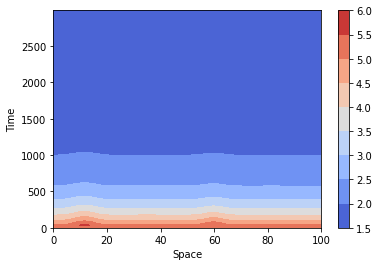

Converged = True, Flat = True, Regular = False
-----------------------------------
1962514.2


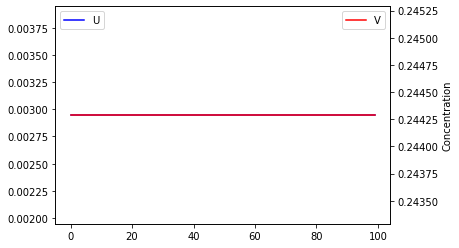

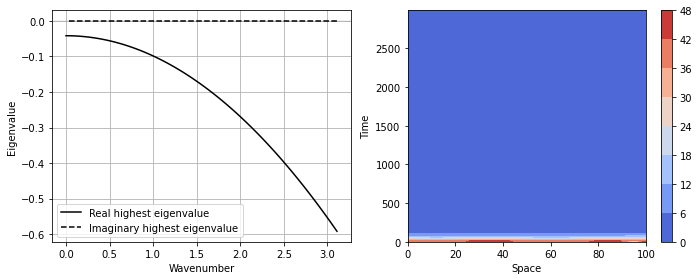

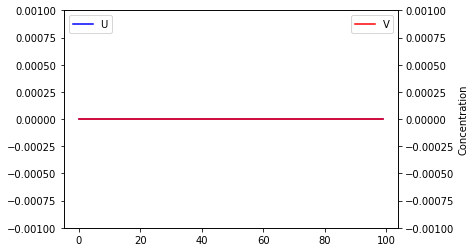

[]
[]
var = [1, 1]


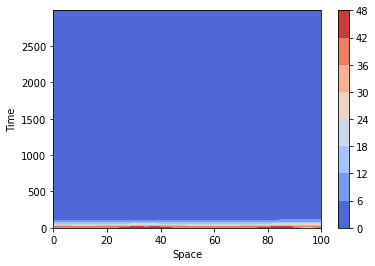

Converged = True, Flat = True, Regular = False
-----------------------------------
94869.0


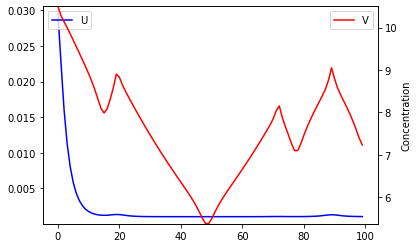

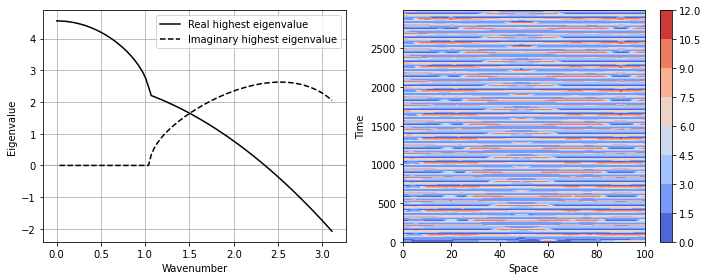

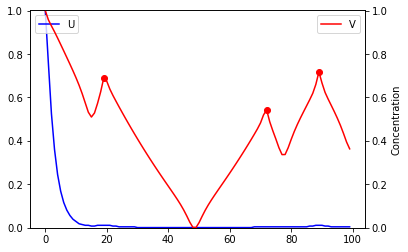

[]
[19 72 89]
var = [1, 0.2571428571428571]


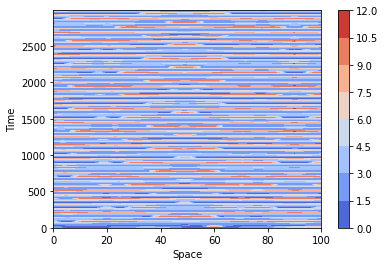

Converged = False, Flat = False, Regular = False
-----------------------------------
890718.0


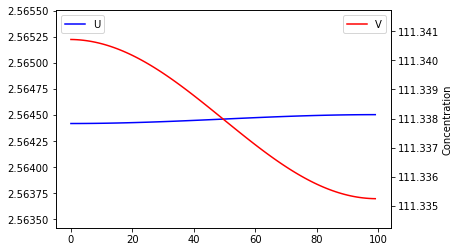

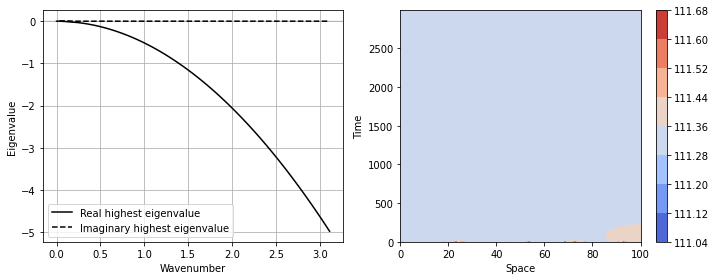

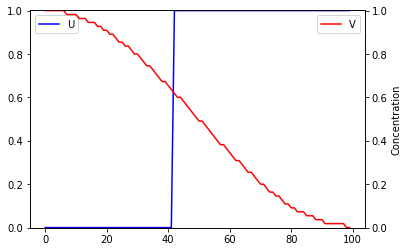

[]
[]
var = [1, 1]


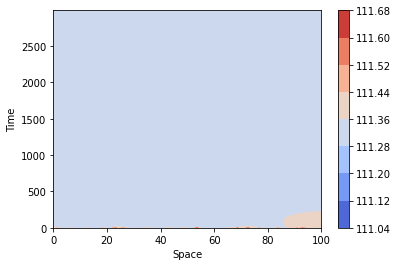

Converged = True, Flat = True, Regular = False
-----------------------------------
1585496.0


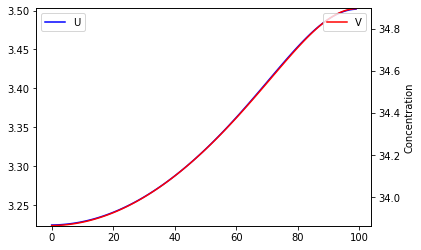

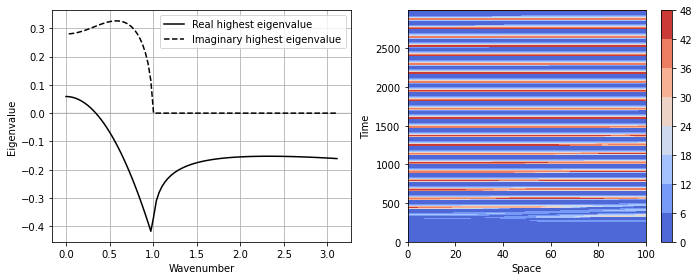

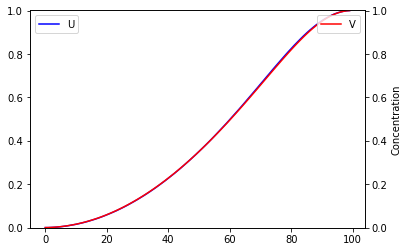

[]
[]
var = [1, 1]


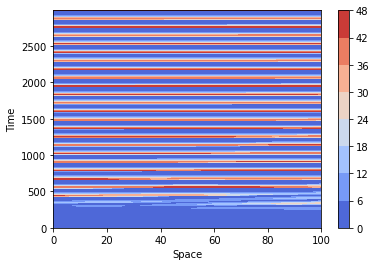

Converged = False, Flat = False, Regular = False
-----------------------------------
1005070.0


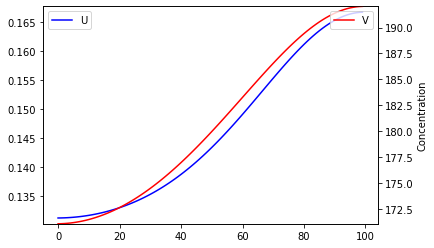

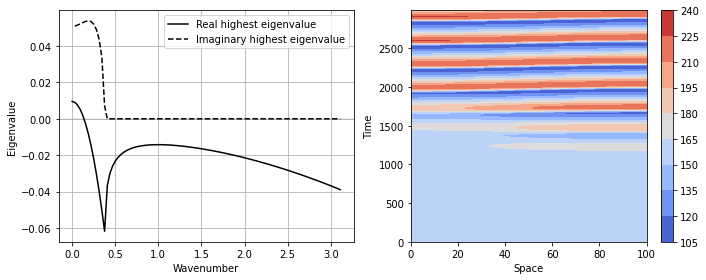

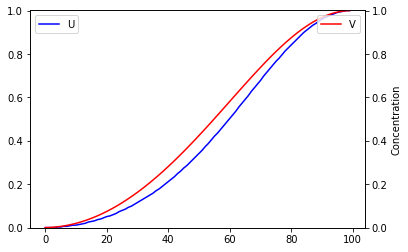

[]
[]
var = [1, 1]


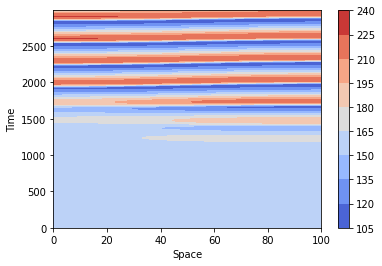

Converged = False, Flat = False, Regular = False
-----------------------------------
1173628.3


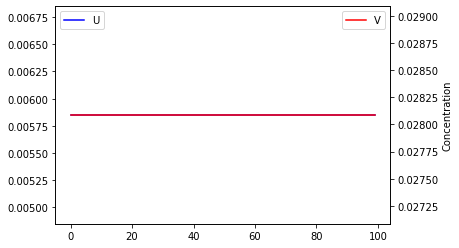

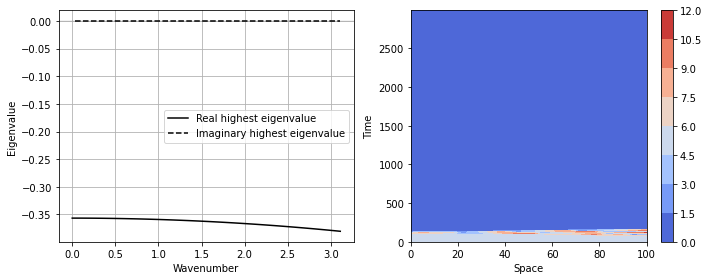

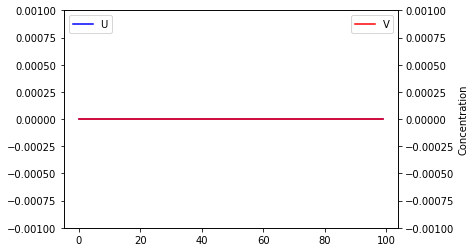

[]
[]
var = [1, 1]


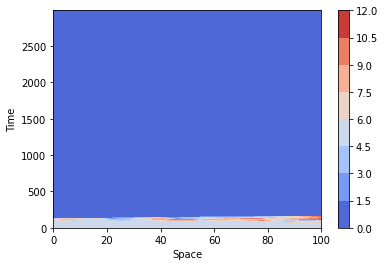

Converged = True, Flat = True, Regular = False
-----------------------------------
470478.0


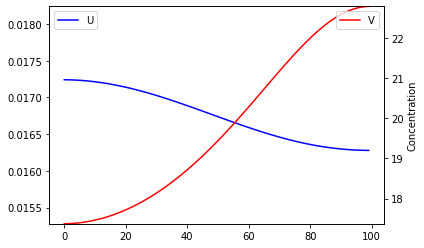

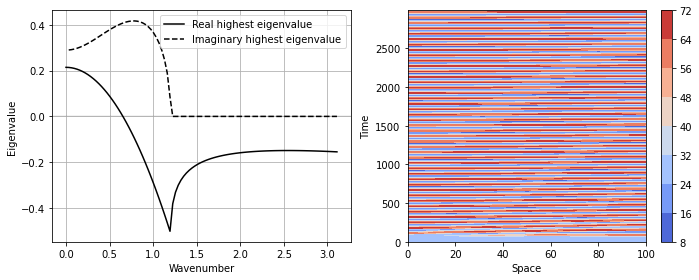

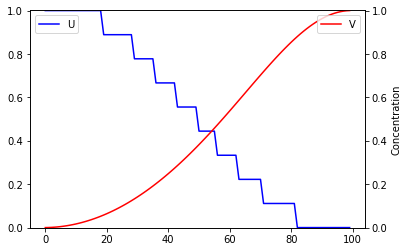

[]
[]
var = [1, 1]


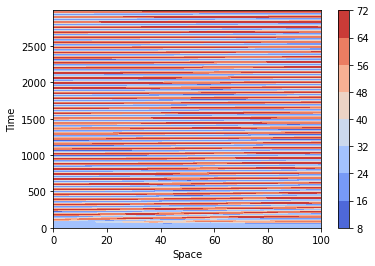

Converged = False, Flat = False, Regular = False
-----------------------------------
1382376.1


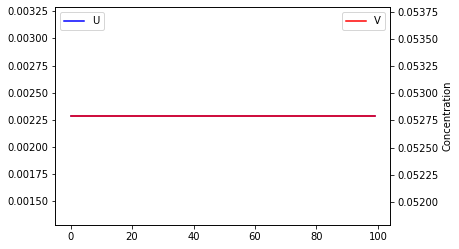

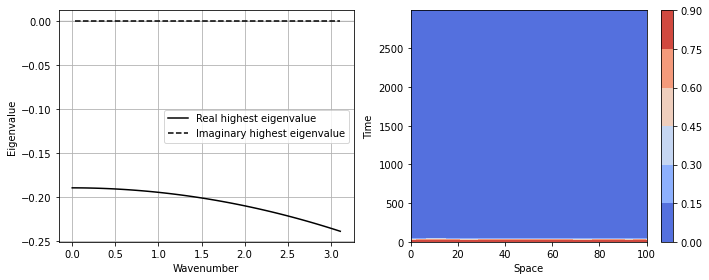

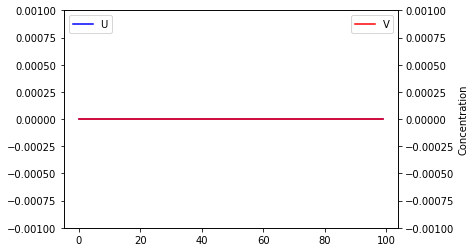

[]
[]
var = [1, 1]


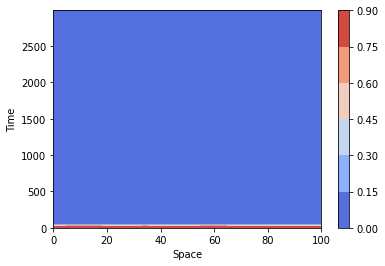

Converged = True, Flat = True, Regular = False
-----------------------------------
1083250.0


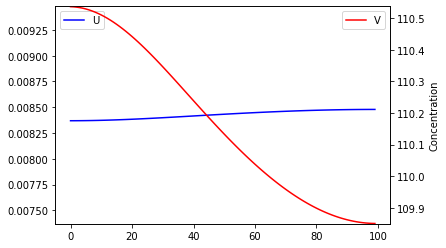

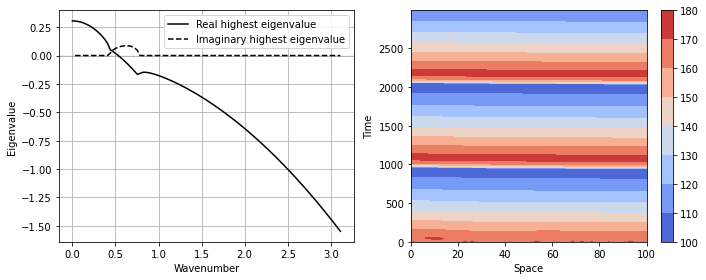

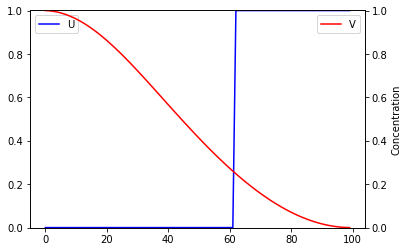

[]
[]
var = [1, 1]


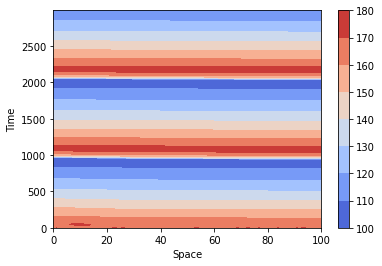

Converged = False, Flat = False, Regular = False
-----------------------------------
1332803.0


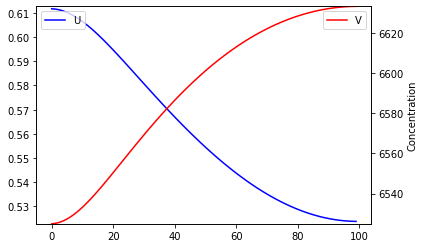

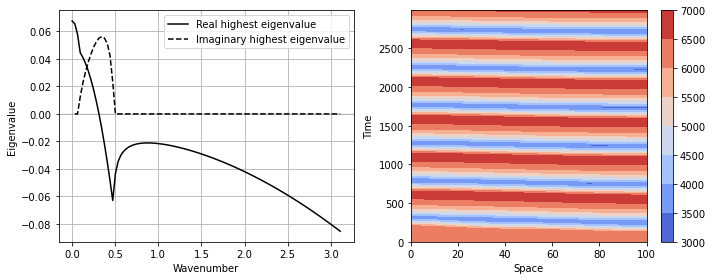

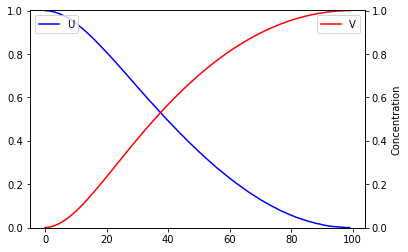

[]
[]
var = [1, 1]


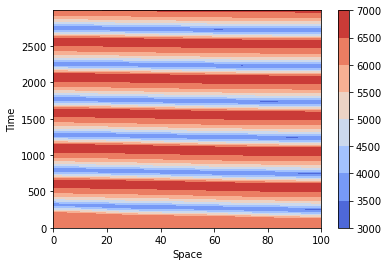

Converged = False, Flat = False, Regular = False
-----------------------------------
1415948.0


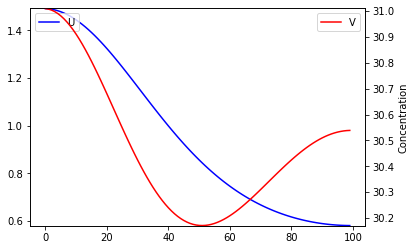

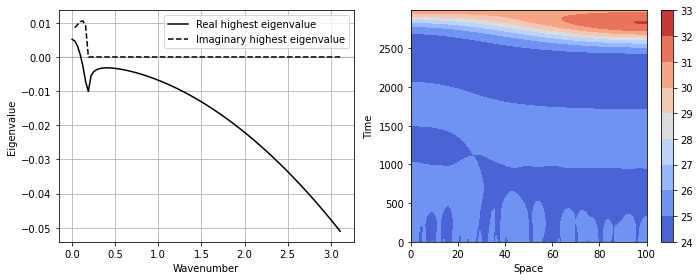

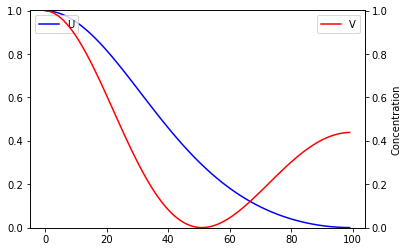

[]
[]
var = [1, 1]


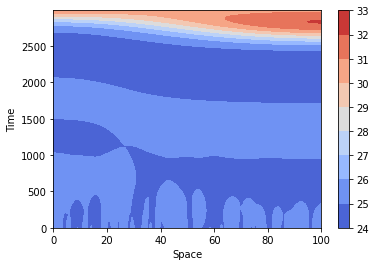

Converged = False, Flat = False, Regular = False
-----------------------------------
125007.2


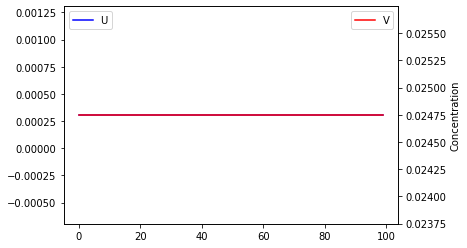

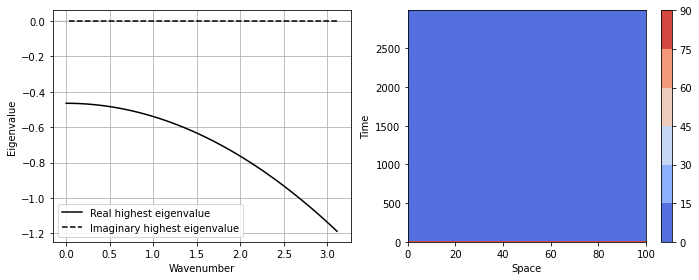

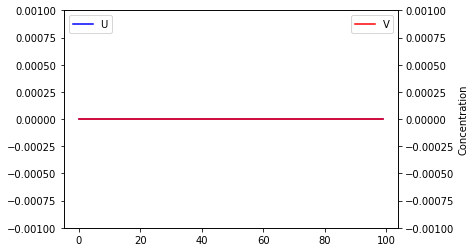

[]
[]
var = [1, 1]


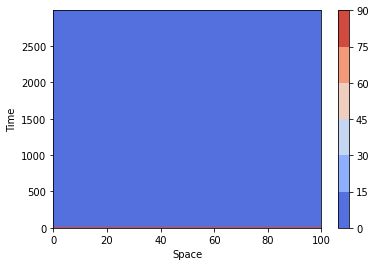

Converged = True, Flat = True, Regular = False
-----------------------------------
760437.2


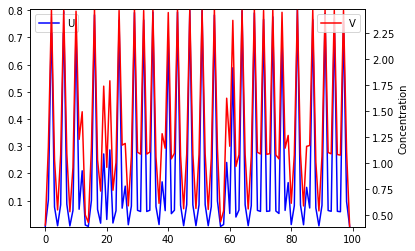

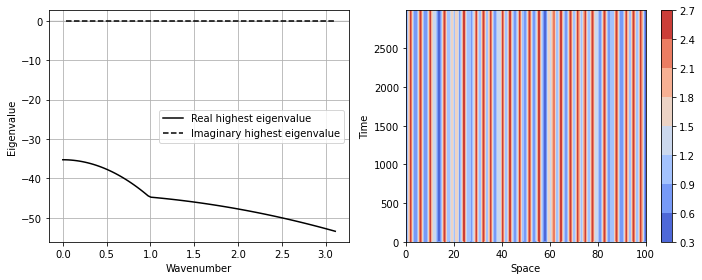

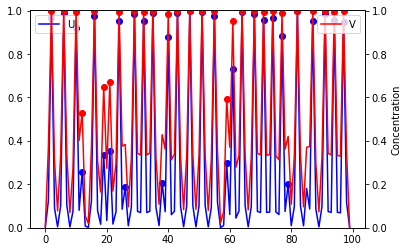

[ 2  6 10 12 16 19 21 24 26 29 32 35 38 40 43 47 51 55 59 61 64 68 71 74
 77 79 82 87 91 94 97]
[ 2  6 10 12 16 19 21 24 29 32 35 40 43 47 51 55 59 61 64 68 71 74 77 82
 87 91 94 97]
var = [0.008191310547318422, 0.009225855412241114]


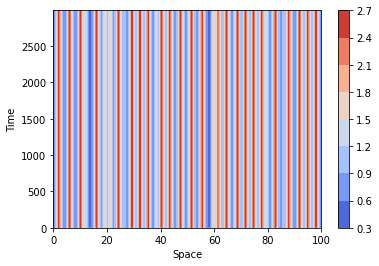

Converged = True, Flat = False, Regular = False
-----------------------------------
1336443.0


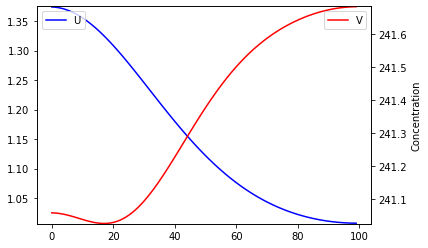

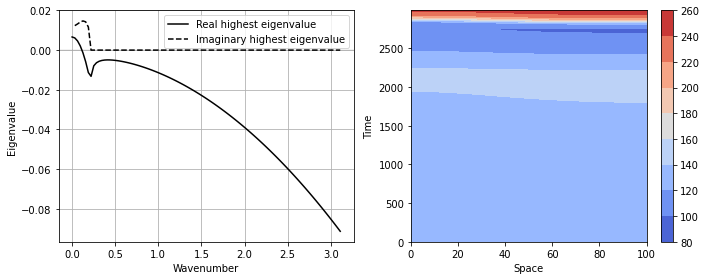

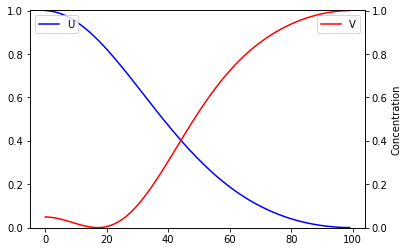

[]
[]
var = [1, 1]


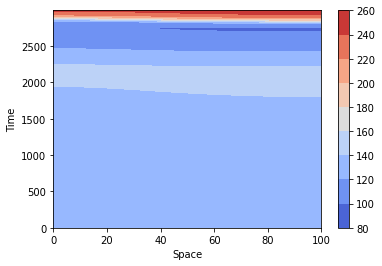

Converged = False, Flat = False, Regular = False
-----------------------------------
266821.0


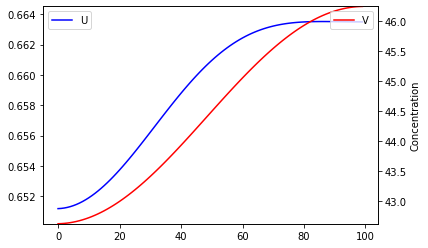

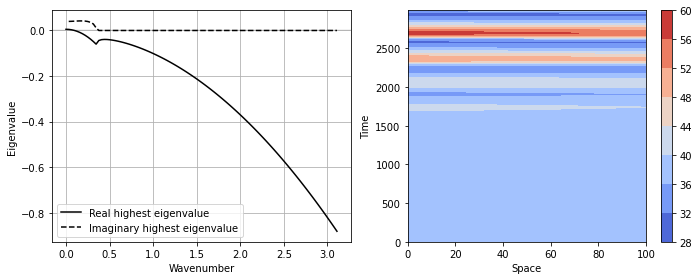

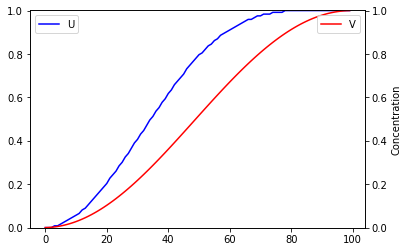

[]
[]
var = [1, 1]


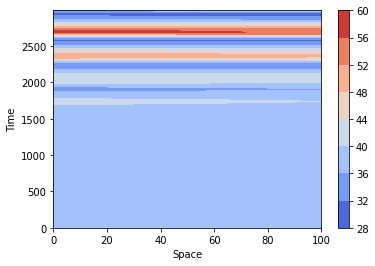

Converged = False, Flat = False, Regular = False
-----------------------------------
1431818.0


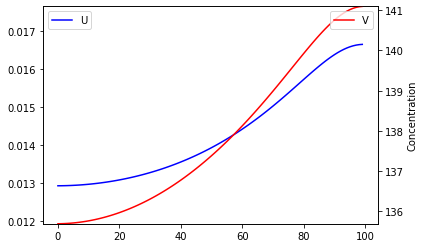

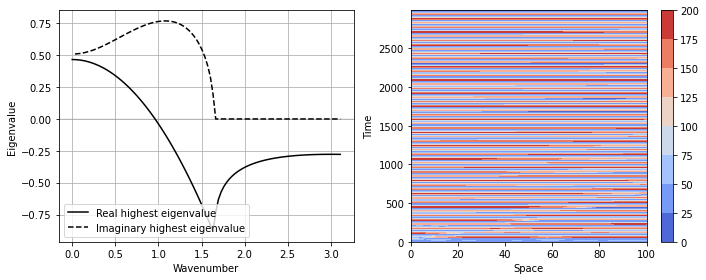

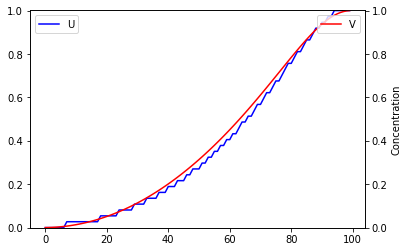

[]
[]
var = [1, 1]


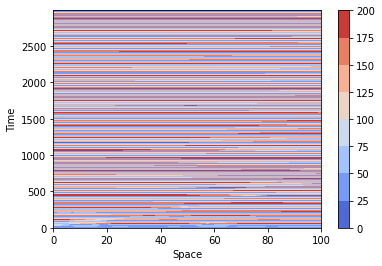

Converged = False, Flat = False, Regular = False
-----------------------------------
263404.0


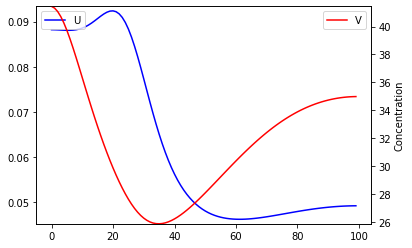

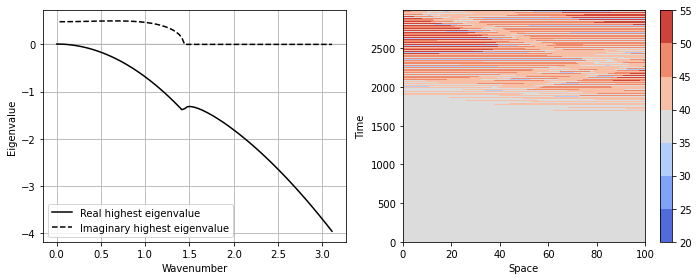

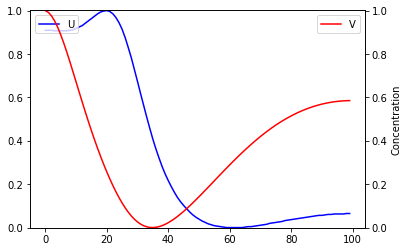

[]
[]
var = [1, 1]


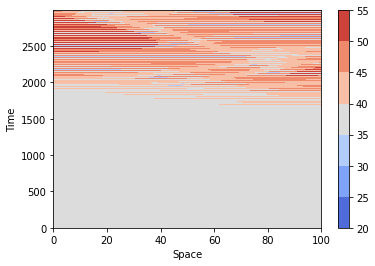

Converged = False, Flat = False, Regular = False
-----------------------------------
589083.0


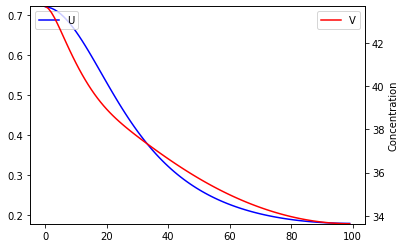

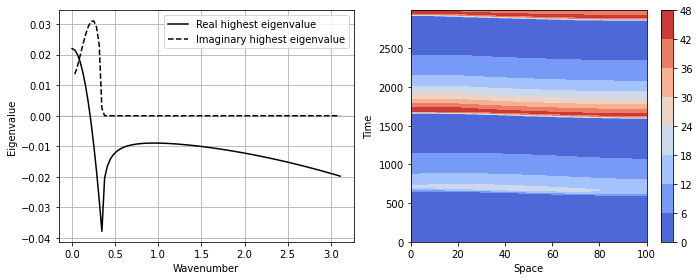

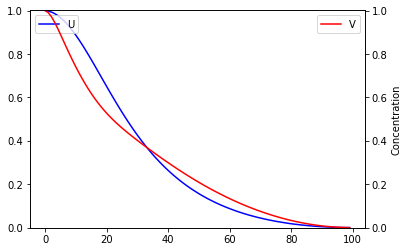

[]
[]
var = [1, 1]


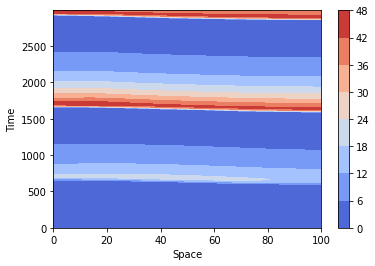

Converged = False, Flat = False, Regular = False
-----------------------------------
336344.0


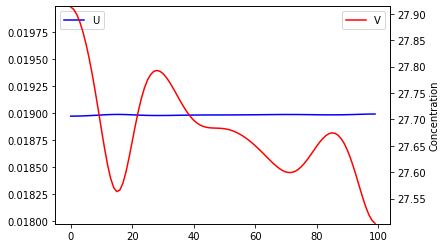

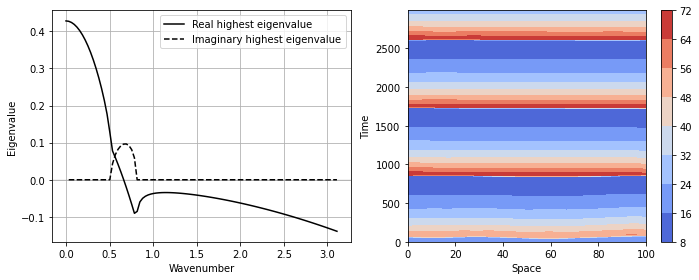

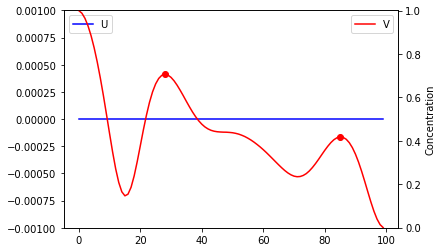

[]
[28 85]
var = [1, 1]


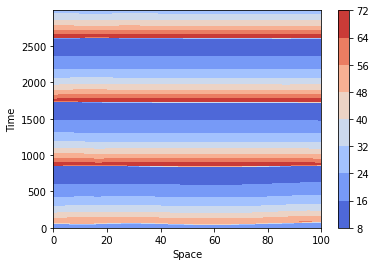

Converged = False, Flat = True, Regular = False
-----------------------------------
515156.0


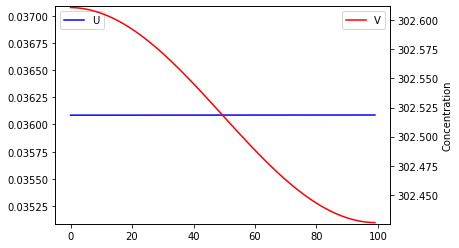

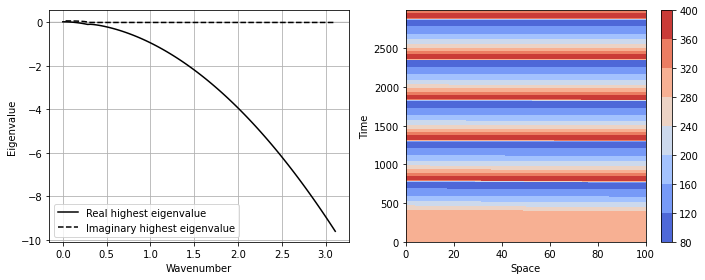

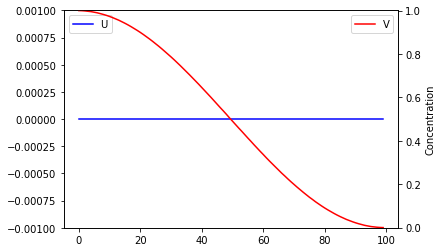

[]
[]
var = [1, 1]


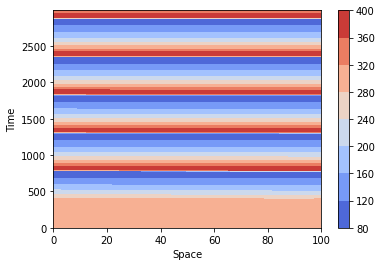

Converged = False, Flat = True, Regular = False
-----------------------------------
583692.2


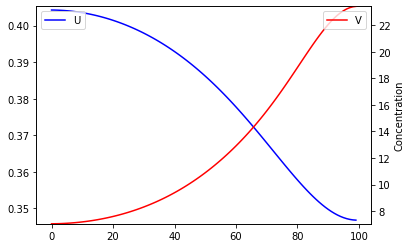

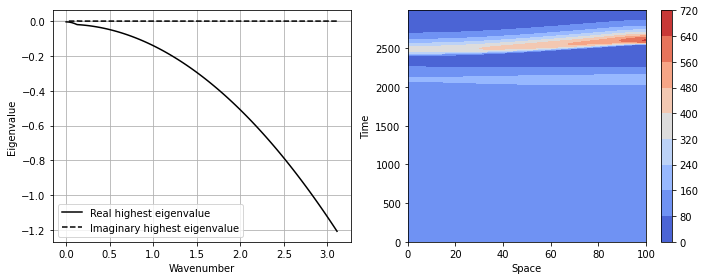

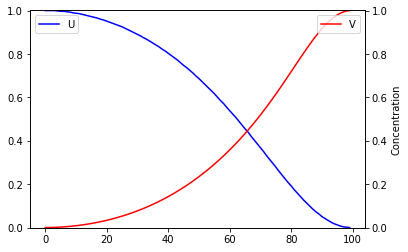

[]
[]
var = [1, 1]


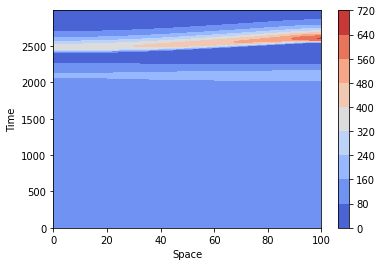

Converged = False, Flat = False, Regular = False
-----------------------------------
996503.3


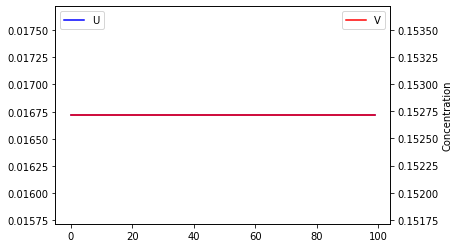

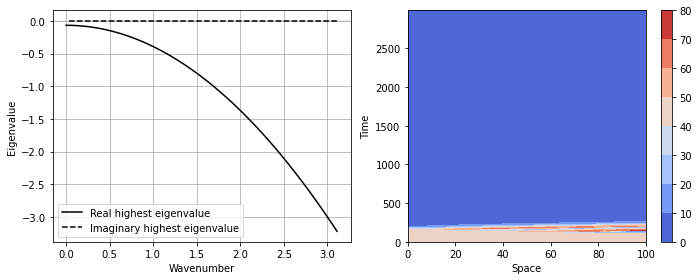

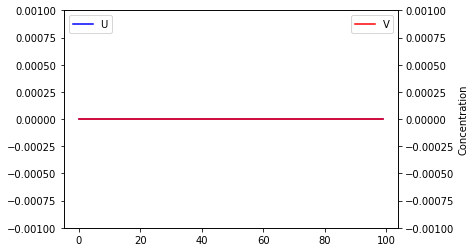

[]
[]
var = [1, 1]


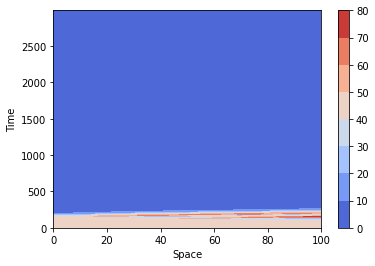

Converged = True, Flat = True, Regular = False
-----------------------------------
1590349.0


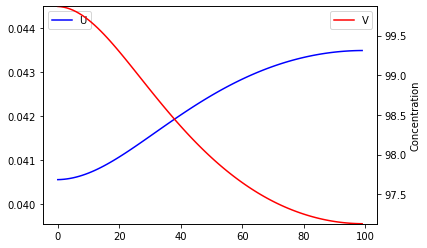

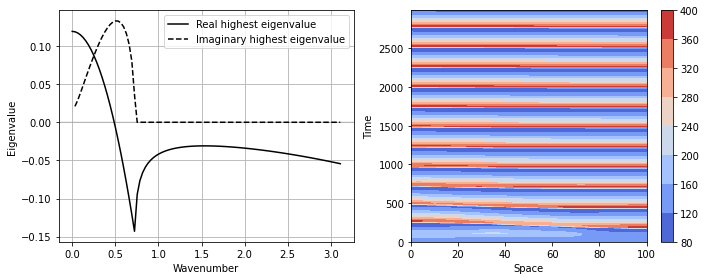

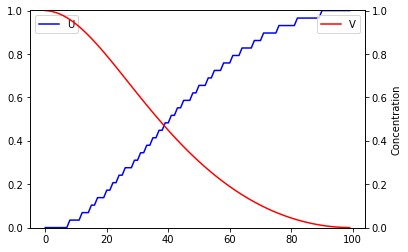

[]
[]
var = [1, 1]


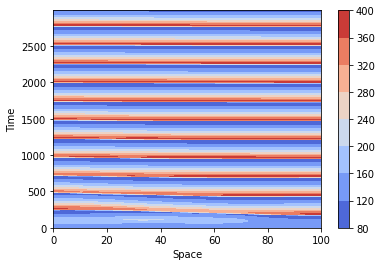

Converged = False, Flat = False, Regular = False
-----------------------------------
622982.2


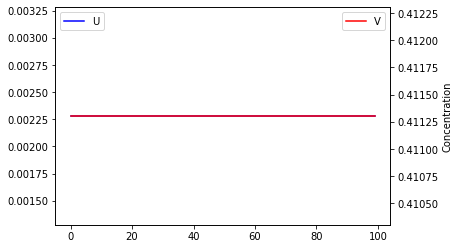

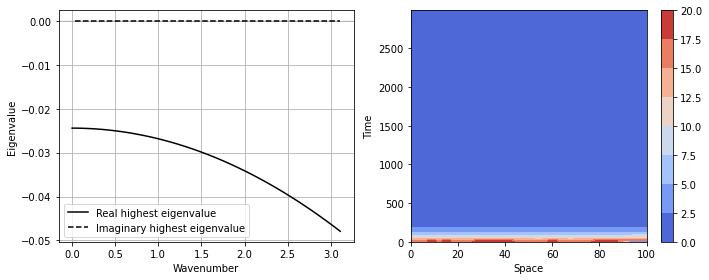

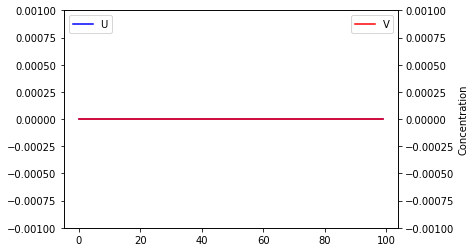

[]
[]
var = [1, 1]


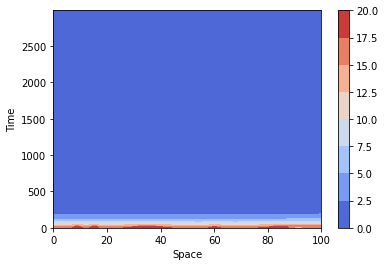

Converged = True, Flat = True, Regular = False
-----------------------------------
1210581.2


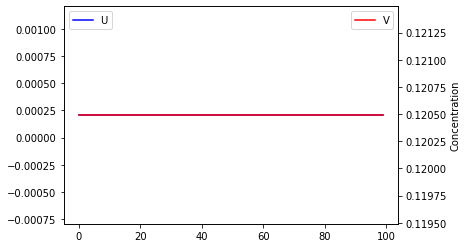

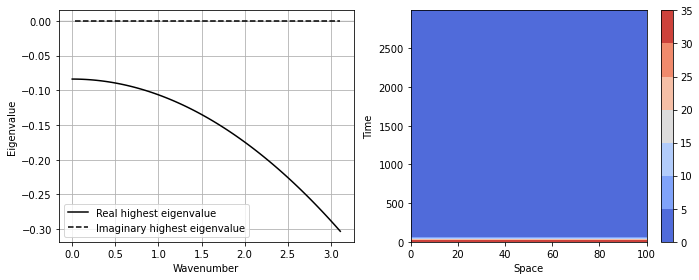

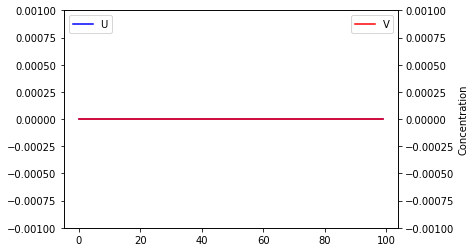

[]
[]
var = [1, 1]


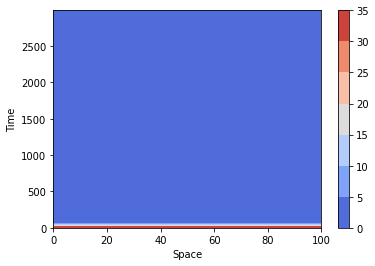

Converged = True, Flat = True, Regular = False
-----------------------------------
1970985.0


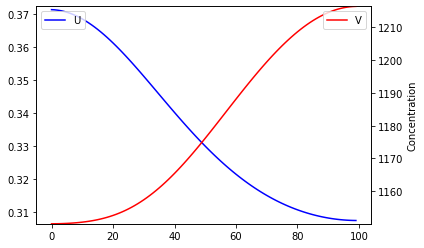

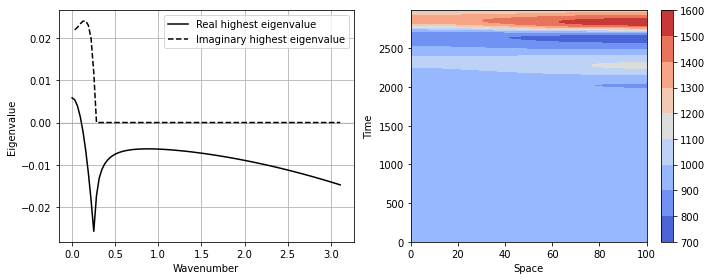

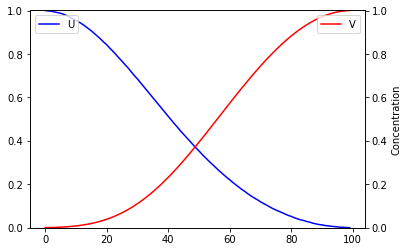

[]
[]
var = [1, 1]


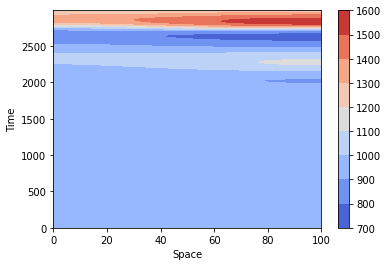

Converged = False, Flat = False, Regular = False
-----------------------------------
1595399.0


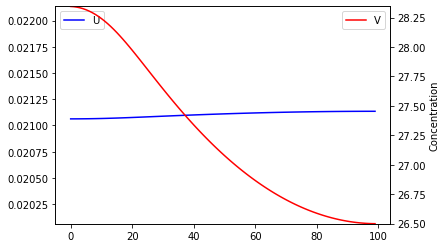

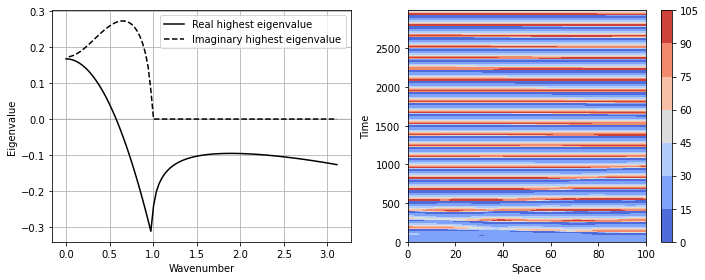

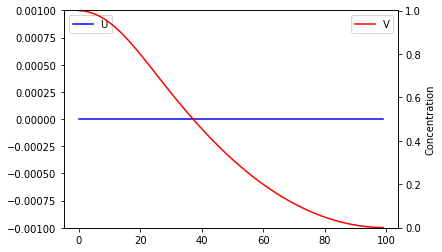

[]
[]
var = [1, 1]


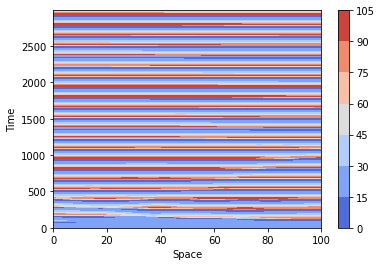

Converged = False, Flat = True, Regular = False
-----------------------------------
140752.2


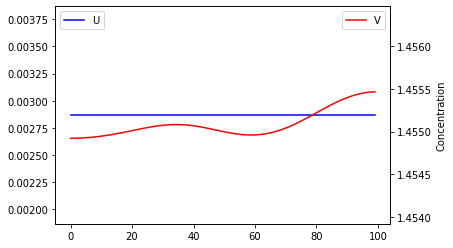

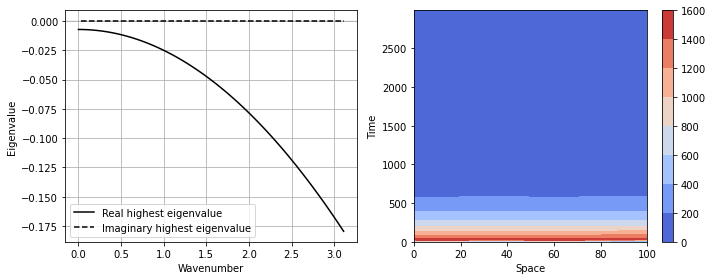

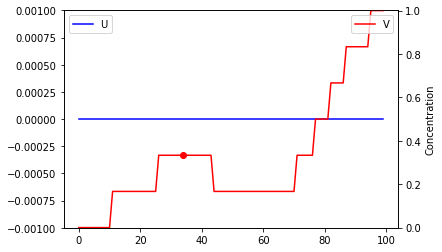

[]
[34]
var = [1, 1]


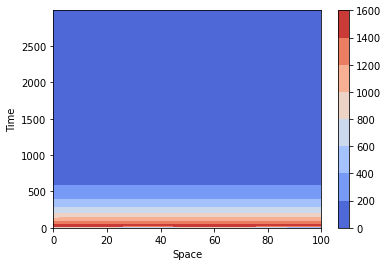

Converged = False, Flat = True, Regular = False
-----------------------------------
166609.0


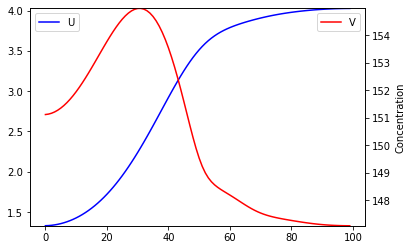

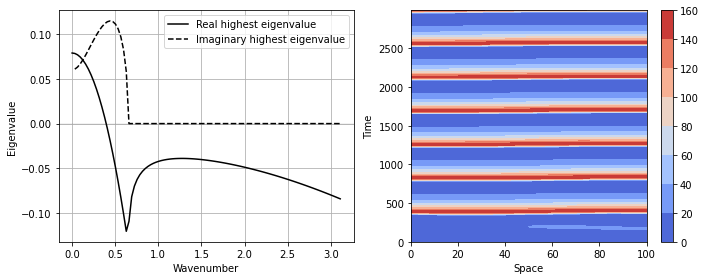

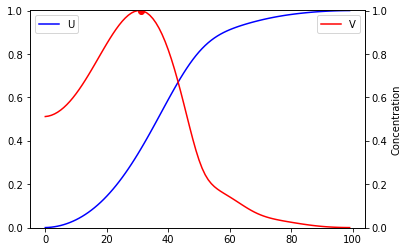

[]
[31]
var = [1, 1]


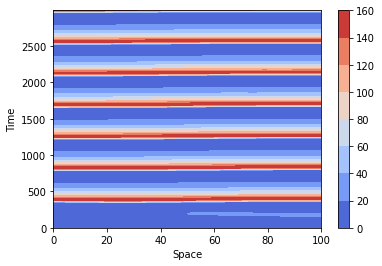

Converged = False, Flat = False, Regular = False
-----------------------------------
417399.0


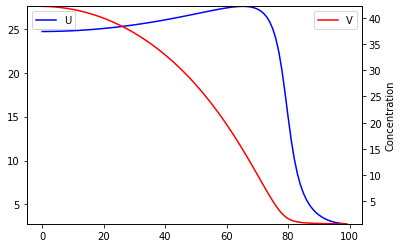

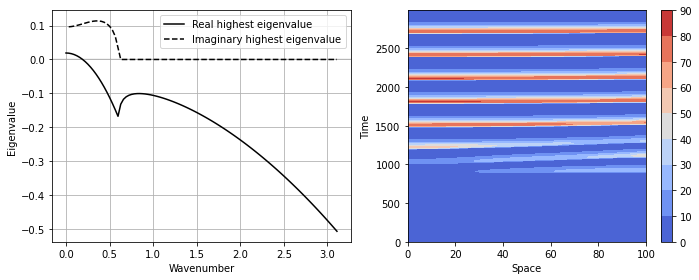

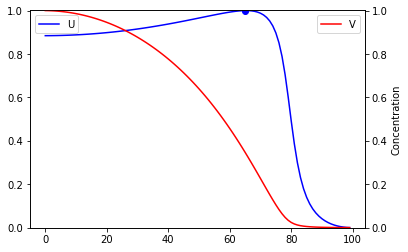

[65]
[]
var = [1, 1]


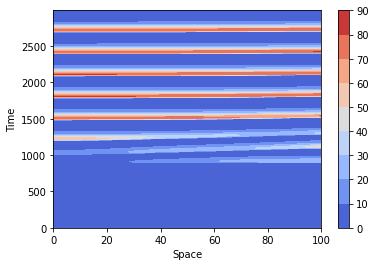

Converged = False, Flat = False, Regular = False
-----------------------------------
16923.2


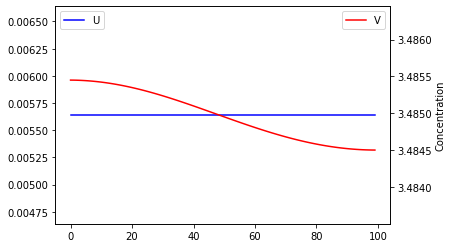

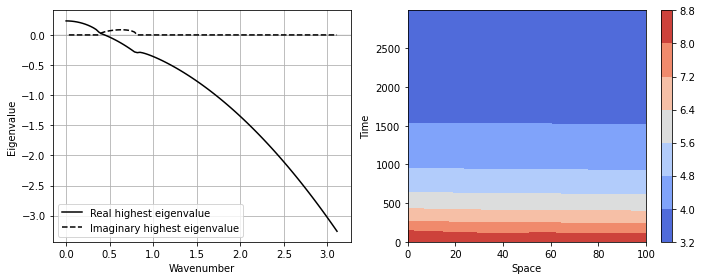

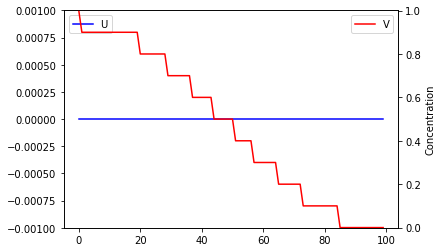

[]
[]
var = [1, 1]


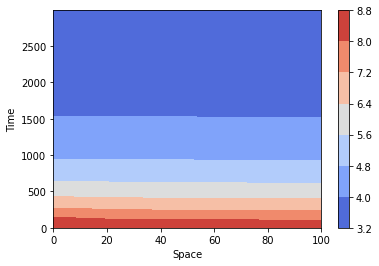

Converged = False, Flat = True, Regular = False
-----------------------------------
929432.0


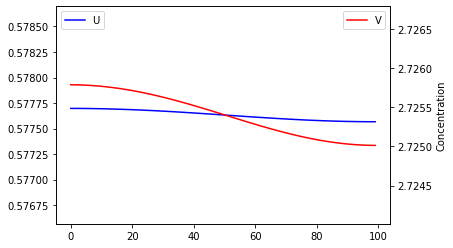

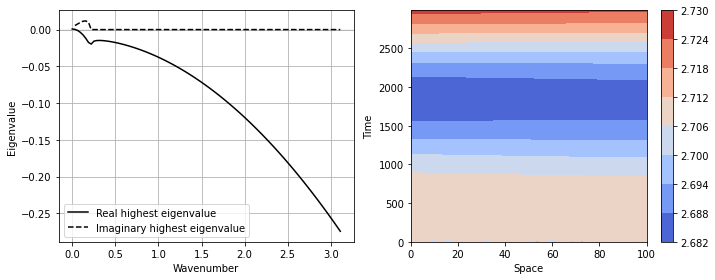

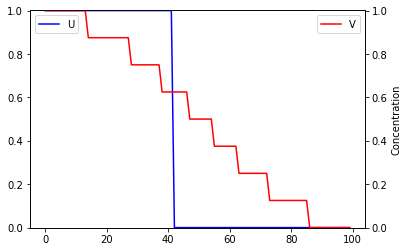

[]
[]
var = [1, 1]


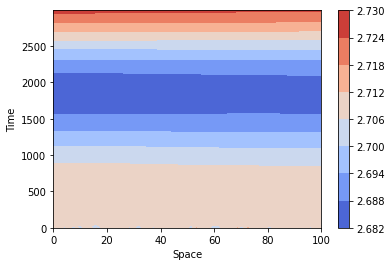

Converged = True, Flat = True, Regular = False
-----------------------------------
1127669.0


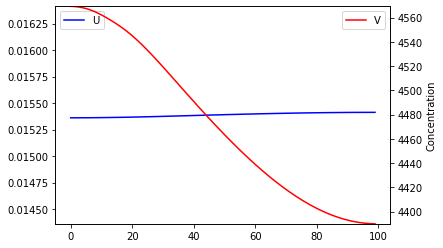

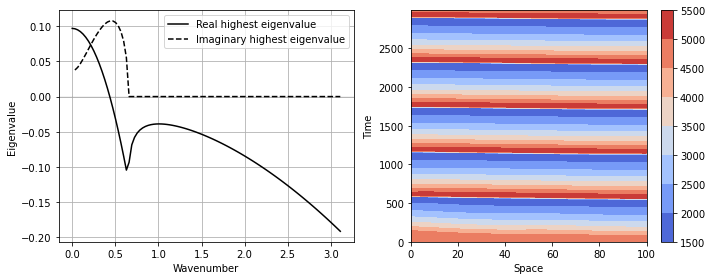

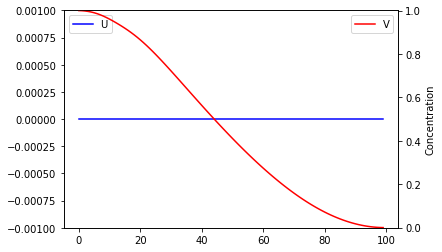

[]
[]
var = [1, 1]


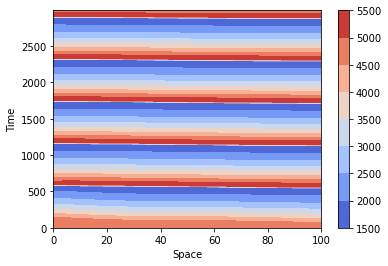

Converged = False, Flat = True, Regular = False
-----------------------------------
842729.0


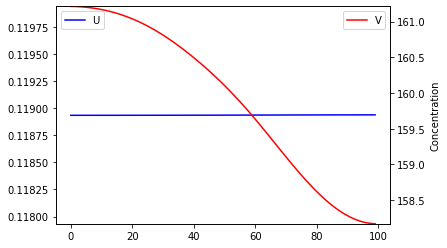

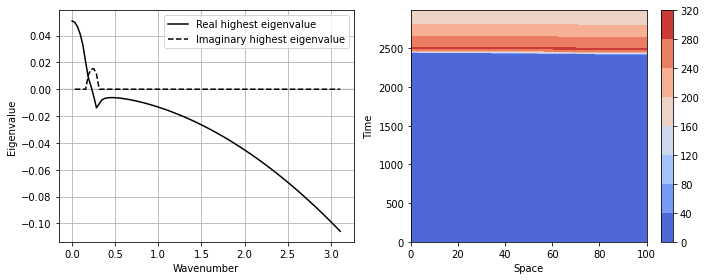

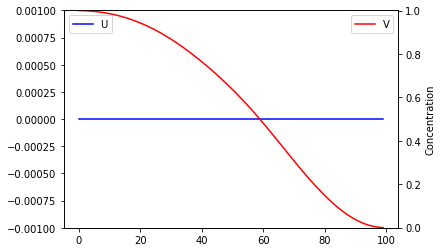

[]
[]
var = [1, 1]


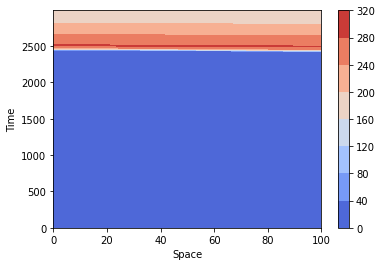

Converged = False, Flat = True, Regular = False
-----------------------------------
1804641.0


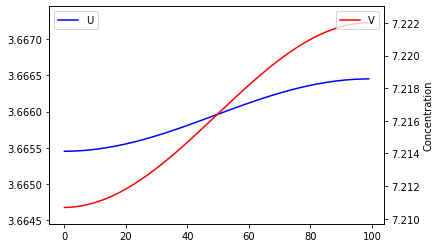

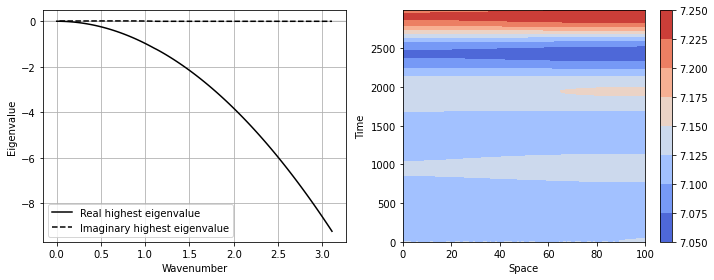

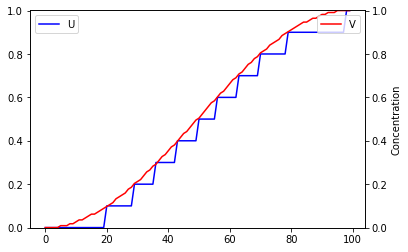

[]
[]
var = [1, 1]


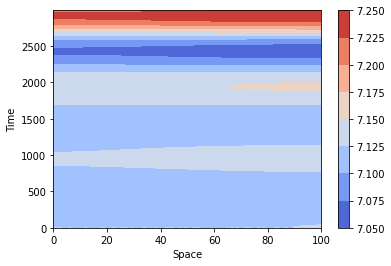

Converged = False, Flat = True, Regular = False
-----------------------------------
1132724.2


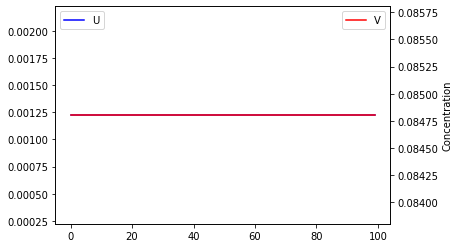

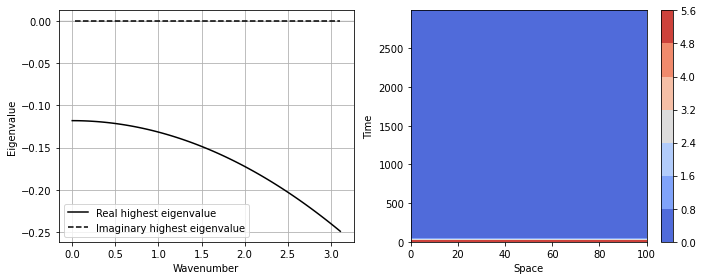

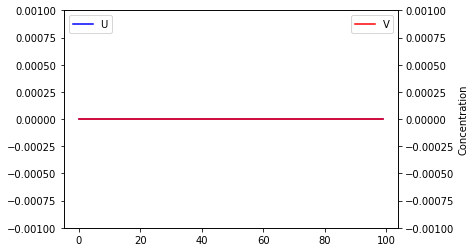

[]
[]
var = [1, 1]


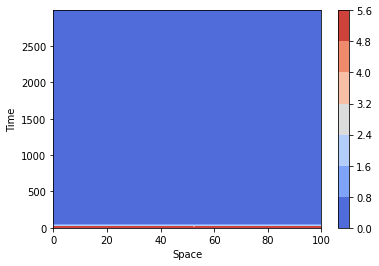

Converged = True, Flat = True, Regular = False
-----------------------------------
1557662.2


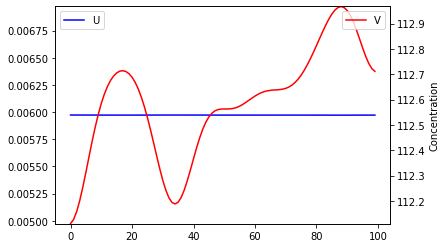

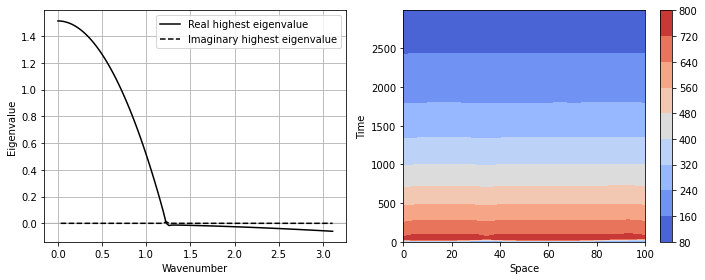

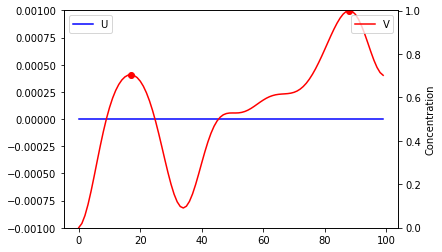

[]
[17 88]
var = [1, 1]


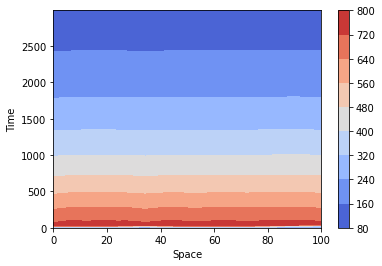

Converged = False, Flat = True, Regular = False
-----------------------------------
1544747.2


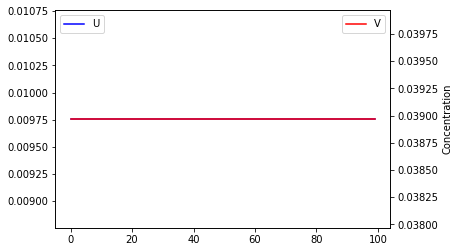

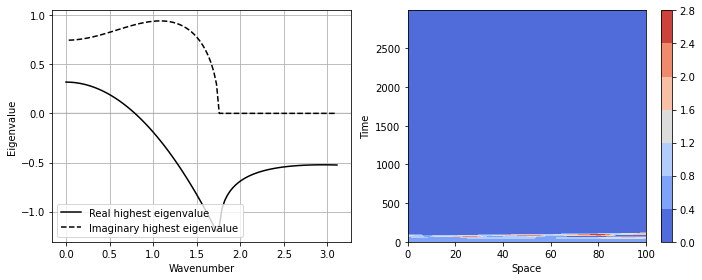

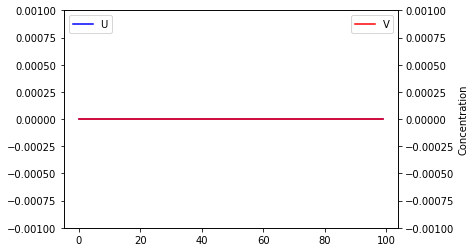

[]
[]
var = [1, 1]


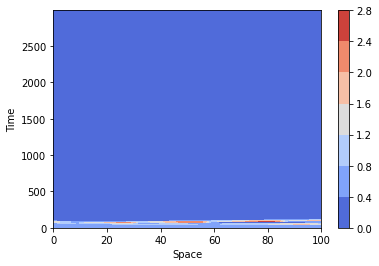

Converged = True, Flat = True, Regular = False
-----------------------------------
1508846.0


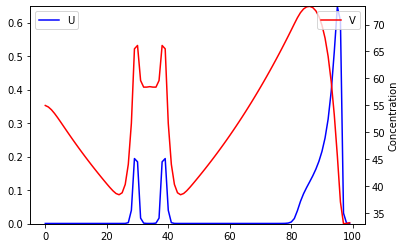

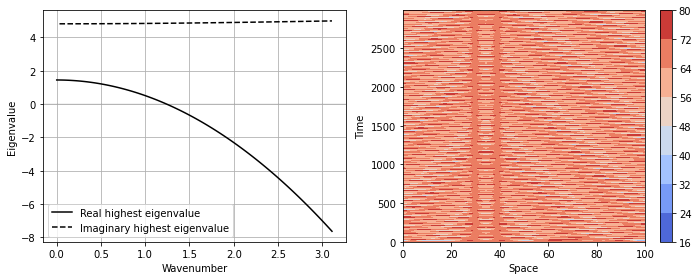

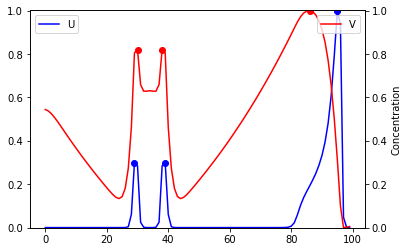

[29 39 95]
[30 38 86]
var = [0.3484848484848485, 0.3571428571428571]


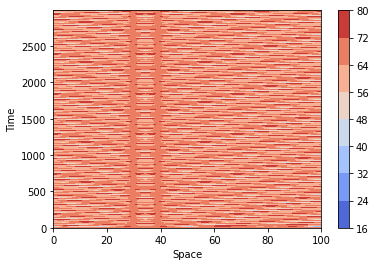

Converged = False, Flat = False, Regular = False
-----------------------------------
1304034.2


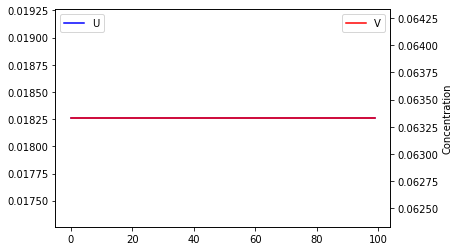

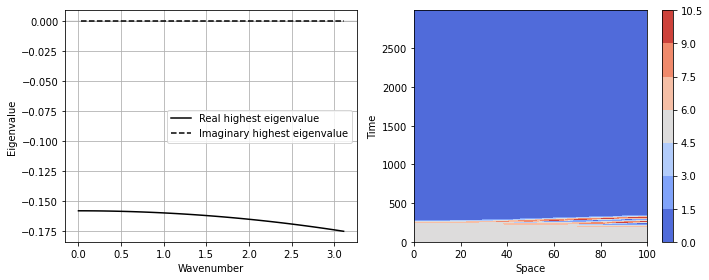

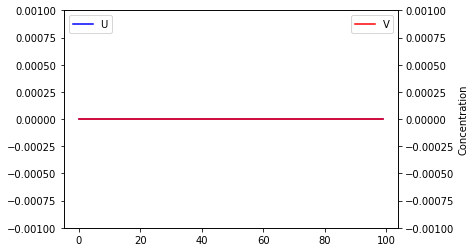

[]
[]
var = [1, 1]


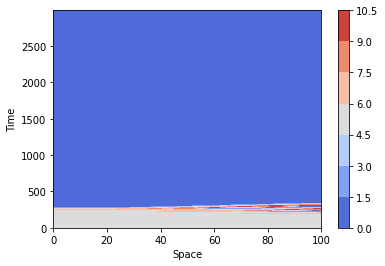

Converged = True, Flat = True, Regular = False
-----------------------------------
384136.0


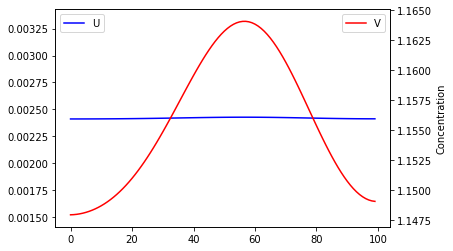

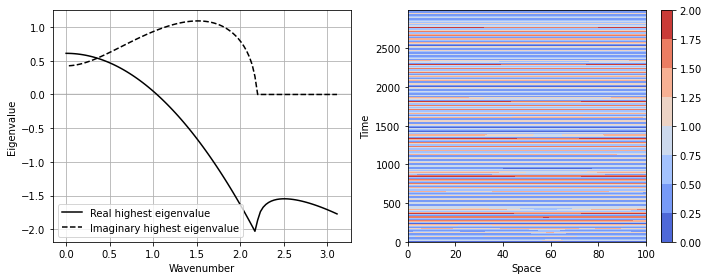

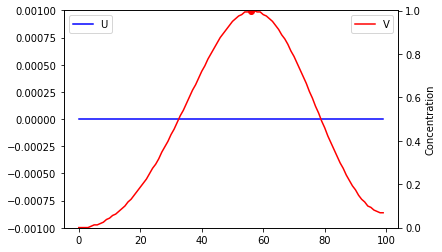

[]
[56]
var = [1, 1]


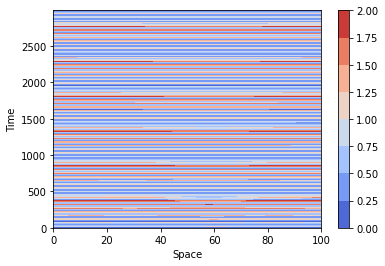

Converged = False, Flat = True, Regular = False
-----------------------------------


In [18]:
for parIDindex in parID_list[20:100]:
    print(parIDindex)
    U_final = pickle.load( open(modellingephemeral + '/growth/out/numerical/%s/%s/simulation/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDindex)), 'rb'))
    parID_display(parIDindex,L,J,T, crop=100)
    # plot1D(U_final,round=False)
    U_final = np.round(U_final,decimals=4)
    U_record = pickle.load( open(modellingephemeral + '/growth/out/numerical/%s/%s/simulation/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDindex)), 'rb'))    
    converged, flat, regular = patternClassification(U_final, U_record)
    # if flat == False:
    parID_surfpattern(parIDindex,L,J,T)
    plt.show()
    print(f'Converged = {converged}, Flat = {flat}, Regular = {regular}')
    print('-----------------------------------')


In [9]:
for parIDindex in df1.index[50:100]:
    # parIDindex = (68,1)    
    par_dict = df1.loc[parIDindex].to_dict() #converts a dataframe row into a dictionary outputing a dictionary for a specific parameter set
    print(par_dict['system_class'])
    print(par_dict['ss_n'])    
    # print(par_dict['pattern'])

    # print(par_dict['d_A'],par_dict['d_B'])

    # #load records 
    parIDss = f'{parIDindex[0]}.{parIDindex[1]}'
    print(parIDss)
    U_final = pickle.load( open(modellingephemeral + '/growth/out/numerical/%s/%s/simulation/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))
    U_record = pickle.load( open(modellingephemeral + '/growth/out/numerical/%s/%s/simulation/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))    


    # parID_display(parIDss,L,J,T, crop=100)
    converged, flat, regular = patternClassification(U_final, U_record)
    # if flat == False:
    parID_display(parIDss,L,J,T, crop=100)
    print(f'Converged = {converged}, Flat = {flat}, Regular = {regular}')

turing I hopf
3.0
77774.2


FileNotFoundError: [Errno 2] No such file or directory: '/rds/general/ephemeral/user/mo2016/ephemeral/Documents/modelling/growth/out/numerical/turinghill/nogrowth/simulation/2Dfinal_circuitturinghill_variant0_bc2_nogrowth_rate0.1_ID77774.2_L100_J100_T3000_N600000.pkl'

In [ ]:
x = np.array([], dtype='int64')
len(x)

0